In [1]:
# Change the path if necessary
datasets_path = 'datasets'

import sys
import os

# Deploy AML code in colab
if 'google.colab' in sys.modules:
    if not os.path.exists('/content/applied-ml/'):
        !wget -q https://raw.githubusercontent.com/tsunrise/colab-github/main/colab_github.py
        import colab_github
        colab_github.github_auth(persistent_key=False)

        %cd /content/
        !git clone git@github.com:oz-e/applied-ml.git
        if not os.path.exists('/content/applied-ml/'):
            raise Exception('Please follow the instructions to add the SSH key to your account in order to clone private repo')

    %cd /content/applied-ml/

    # Install any other requirements (to be converted to requirements.txt)
    !pip install openai-clip

In [2]:
import os

if not os.path.exists('CuPL'):
    !git clone https://github.com/sarahpratt/CuPL.git

In [3]:
import numpy as np
import torch
import clip
import json
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import defaultdict
from CuPL.imagenet_prompts.standard_image_prompts import imagenet_templates

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
model, preprocess = clip.load('ViT-B/16', device=device, jit=False)

In [6]:
import aml.datasets

dataset_test = aml.datasets.UCF101(datasets_path, split='test')

In [7]:
cls_names_sorted = [dataset_test.lab2cname[label_id] for label_id in sorted(dataset_test.lab2cname.keys())]

In [8]:
# Create class name features
with torch.no_grad():
    cls_name_label_ids = np.arange(len(cls_names_sorted))
    cls_name_features_cuda = model.encode_text(clip.tokenize(cls_names_sorted).to(device))
    cls_name_features_cuda /= cls_name_features_cuda.norm(dim=-1, keepdim=True)
    cls_name_features = cls_name_features_cuda.cpu().numpy()

    # Fill diagonal for better visibility
    cls_name_masked_similarity = (cls_name_features_cuda @ cls_name_features_cuda.T).fill_diagonal_(float('nan')).cpu().numpy()

In [9]:
def calc_features(encoder, items_dict):
    with torch.no_grad():
        label_ids = []
        features_cuda = []
        cls_features_cuda = []
        for label_id in tqdm(range(len(cls_names_sorted))):
            items = items_dict.pop(label_id)
            label_ids.append([label_id] * len(items))
            class_embeddings = encoder(items)
            class_embeddings /= class_embeddings.norm(dim=-1, keepdim=True)
            class_embedding = class_embeddings.mean(dim=0)
            class_embedding /= class_embedding.norm()
            features_cuda.append(class_embeddings)
            cls_features_cuda.append(class_embedding)
        label_ids = np.hstack(label_ids)
        features = torch.vstack(features_cuda).cpu().numpy()
        cls_features_cuda = torch.vstack(cls_features_cuda)

        # Fill diagonal for better visibility
        masked_similarity = (cls_features_cuda @ cls_features_cuda.T).fill_diagonal_(float('nan')).cpu().numpy()

    return label_ids, features, features_cuda, cls_features_cuda, masked_similarity

In [10]:
def encode_text(texts):
    with torch.no_grad():
        return model.encode_text(clip.tokenize(texts).to(device))

In [11]:
# Create template text features
template_label_texts_list = {label_id: [template.format(cls_name) for template in imagenet_templates] for label_id, cls_name in enumerate(cls_names_sorted)}
template_label_ids, template_text_features, template_text_features_cuda, template_cls_features_cuda, template_masked_similarity = calc_features(encode_text, template_label_texts_list)

100%|██████████| 101/101 [00:02<00:00, 49.65it/s]


In [12]:
PATH_TO_PROMPTS = './CuPL/all_prompts/full_prompts/ucf_prompts_full.json'

with open(PATH_TO_PROMPTS) as f:
    gpt3_prompts_file = json.load(f)

In [13]:
# Mapping between CuPL and cls_name
special_class_mapping = {
    'Hand Stand Pushups': 'Handstand_Pushups'
}

In [14]:
# Lookup CuLP prompts from cls_name
original_gpt3_prompts = {}

for gpt3_cls_name, texts in gpt3_prompts_file.items():
    cls_name = special_class_mapping.get(gpt3_cls_name, gpt3_cls_name).replace(' ', '_')
    if cls_name not in dataset_test.classnames:
        continue
    original_gpt3_prompts[cls_name] = texts

In [15]:
# Create original gpt3 text features
original_gpt3_label_texts_list = {label_id: original_gpt3_prompts[cls_name] for label_id, cls_name in enumerate(cls_names_sorted)}
original_gpt3_label_ids, original_gpt3_text_features, original_gpt3_text_features_cuda, original_gpt3_cls_features_cuda, original_gpt3_masked_similarity = calc_features(encode_text, original_gpt3_label_texts_list)

100%|██████████| 101/101 [00:01<00:00, 75.41it/s]


In [16]:
# Hyperparameters for filtering outliers in gpt3 texts

# Minimum mean similarity
similarity_mean_threshold = 0.7

# Minimum similarity to be counted as dissimilar
similarity_count_threshold = 0.65
# Filter if it is dissimilar from more than (1-ratio) of the other texts
similarity_count_ratio = 0.5

In [17]:
# Filter out outliers in gpt3 text features
with torch.no_grad():
    # Remove duplicates
    unique_gpt3_prompts = {label_id: list(dict.fromkeys(original_gpt3_prompts[cls_name])) for label_id, cls_name in enumerate(cls_names_sorted)}
    _, _, unique_gpt3_text_features_cuda, _, _ = calc_features(encode_text, unique_gpt3_prompts.copy())

    unique_gpt3_text_similarity = [(features_cuda @ features_cuda.T).fill_diagonal_(float('nan')).cpu().numpy() for features_cuda in unique_gpt3_text_features_cuda]
    unique_gpt3_text_similarity_mean = [np.nanmean(similarity, axis=0) for similarity in unique_gpt3_text_similarity]
    unique_gpt3_text_similarity_count_mean = [(similarity >= similarity_count_threshold).mean(axis=0) for similarity in unique_gpt3_text_similarity]
    filtered_gpt3_prompts = {label_id: [text for text, similarity_mean, similarity_count in zip(texts, similarity_means, similarity_counts) if similarity_mean >= similarity_mean_threshold and similarity_count >= similarity_count_ratio] for (label_id, texts), similarity_means, similarity_counts in zip(unique_gpt3_prompts.items(), unique_gpt3_text_similarity_mean, unique_gpt3_text_similarity_count_mean)}
    # Print filtered prompts
    outlier_gpt3_prompts = {label_id: [text for text, similarity_mean, similarity_count in zip(texts, similarity_means, similarity_counts) if not (similarity_mean >= similarity_mean_threshold and similarity_count >= similarity_count_ratio)] for (label_id, texts), similarity_means, similarity_counts in zip(unique_gpt3_prompts.items(), unique_gpt3_text_similarity_mean, unique_gpt3_text_similarity_count_mean)}
    top_filtered_label_id = None
    top_filtered_count = 0
    for label_id, texts in outlier_gpt3_prompts.items():
        filtered_count = len(texts)
        if filtered_count != 0:
            print(f'Filtered {filtered_count} outliers for ({label_id}){cls_names_sorted[label_id]}')
            print(texts)
            print()
            if filtered_count > top_filtered_count:
                top_filtered_count = filtered_count
                top_filtered_label_id = label_id

100%|██████████| 101/101 [00:01<00:00, 85.86it/s]

Filtered 1 outliers for (6)Baseball_Pitch
["A person stands on a pitcher's mound, holding a baseball."]

Filtered 1 outliers for (9)Bench_Press
['http://www.']

Filtered 2 outliers for (11)Billiards
[' ReboundIf a ball hits another ball head-on, it will bounce off at an angle.', 'There is no one definitive answer to this question.']

Filtered 1 outliers for (12)Blow_Dry_Hair
['](https://www.']

Filtered 1 outliers for (13)Blowing_Candles
['N/A.']

Filtered 1 outliers for (14)Body_Weight_Squats
[' see link.']

Filtered 1 outliers for (16)Boxing_Punching_Bag
['There is no one definitive answer to this question.']

Filtered 1 outliers for (17)Boxing_Speed_Bag
['The person looks like they are punching the air in front of them.']

Filtered 1 outliers for (20)Clean_And_Jerk
['CJ is the second phase of the clean.']

Filtered 2 outliers for (25)Diving
[' beamA diving beam is a searchlight that is used to illuminate an area from above.', ' DeadThis card forces each player to put the top card of

Class: (88)Swing
(0) Toolkit:The action of Swing Toolkit is to provide a set of tools for creating and managing graphical user interface (GUI) components, as well as other related software components, for Java programs.
(2) JDBCSwing JDBC is a Java library that provides a simple way to access databases using the Java Database Connectivity (JDBC) API.
(5)JS' dialXxx methodsThe methods setVisible() and setEnabled() can be used to hide or show a component, and to enable or disable a component, respectively.
(6) DoorA swing door is a door that is attached to a hinge on one side and opens outward in a swinging motion.
(7)Utilities.
(8)When using the Swing library, developers can create graphical user interface (GUI) components, such as buttons and labels, that are displayed on a window.
(30)In computer programming, swing is a software toolkit for creating graphical user interface (GUI) components, meant to be replaced by the JavaFX toolkit.


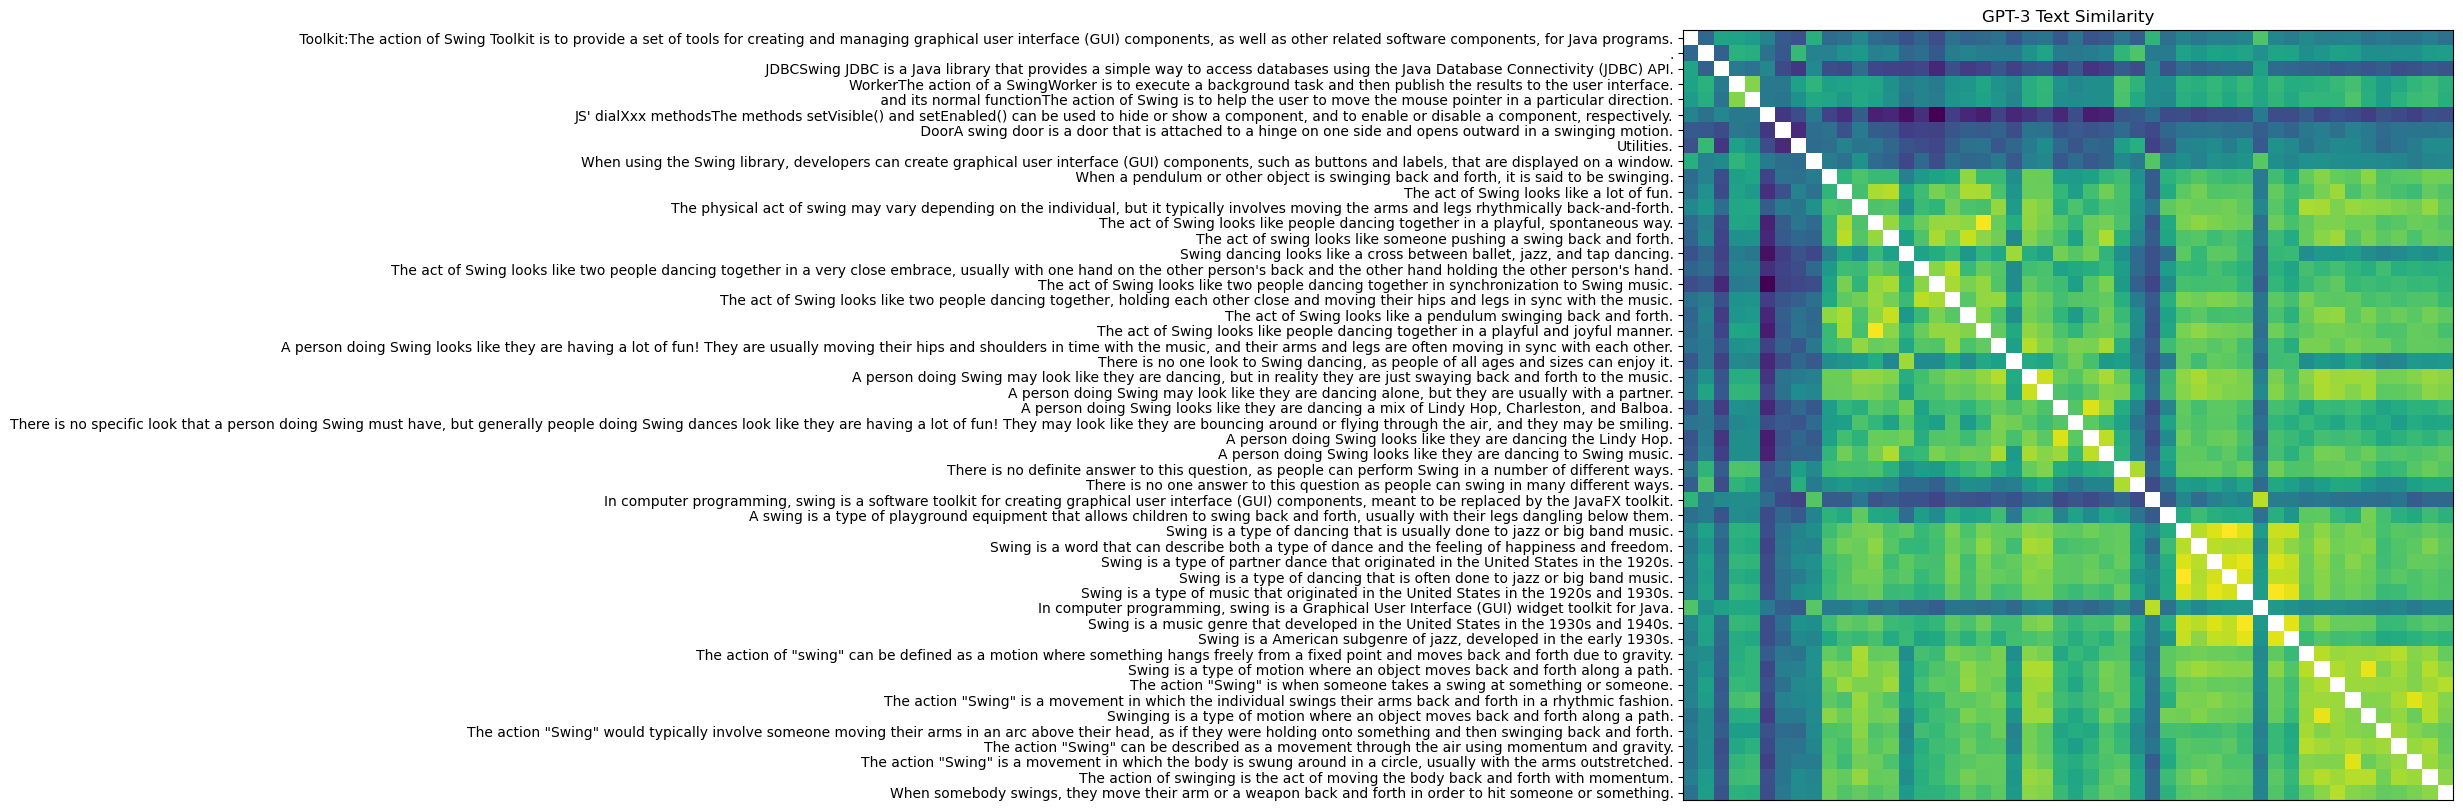

In [18]:
# Visualize dis-similarities of outliers
print(f'Class: ({top_filtered_label_id}){cls_names_sorted[top_filtered_label_id]}')
ylabels = unique_gpt3_prompts[top_filtered_label_id]
for text in outlier_gpt3_prompts[top_filtered_label_id]:
    print(f'({ylabels.index(text)}){text}')
plt.figure(figsize=(12, 10))
plt.imshow(unique_gpt3_text_similarity[top_filtered_label_id])
plt.xticks([])
plt.yticks(np.arange(0, len(ylabels)), ylabels)
plt.title('GPT-3 Text Similarity')
plt.show()

In [19]:
# Create filtered gpt3 text features
filtered_gpt3_label_texts_list = {label_id: filtered_gpt3_prompts[label_id] for label_id in range(len(cls_names_sorted))}
filtered_gpt3_label_ids, filtered_gpt3_text_features, filtered_gpt3_text_features_cuda, filtered_gpt3_cls_features_cuda, filtered_gpt3_masked_similarity = calc_features(encode_text, filtered_gpt3_label_texts_list)

100%|██████████| 101/101 [00:01<00:00, 86.55it/s]


In [20]:
def encode_images(imgs):
    with torch.no_grad():
        return model.encode_image(torch.stack([preprocess(img) for img in imgs]).to(device))

In [21]:
# Create image features
imgs_grouped = defaultdict(list)
for img, label_id in dataset_test:
    imgs_grouped[label_id].append(img)
img_label_ids, _, img_features_cuda, _, img_masked_similarity = calc_features(encode_images, imgs_grouped)

100%|██████████| 101/101 [00:10<00:00,  9.29it/s]


In [22]:
import sklearn.metrics

def calc_clip_pred(label_ids, img_features_cuda, text_features_cuda):
    with torch.no_grad():
        if type(text_features_cuda) == list:  # list of tensors
            logits = torch.vstack([(img_features_cuda @ embeddings.T).mean(dim=-1) for embeddings in text_features_cuda]).T
        else:
            logits = img_features_cuda @ text_features_cuda.T
        pred = logits.argmax(dim=-1).cpu().numpy()

        return (pred == label_ids).mean(), sklearn.metrics.confusion_matrix(label_ids, pred, labels=np.arange(len(cls_names_sorted)), normalize='true')

In [23]:
# Combine template text with gpt3 text features
combined_original_gpt3_text_features_cuda = [torch.vstack((text_features1, text_features2)) for text_features1, text_features2 in zip(template_text_features_cuda, original_gpt3_text_features_cuda)]
combined_filtered_gpt3_text_features_cuda = [torch.vstack((text_features1, text_features2)) for text_features1, text_features2 in zip(template_text_features_cuda, filtered_gpt3_text_features_cuda)]
combined_original_gpt3_cls_features_cuda = []
combined_filtered_gpt3_cls_features_cuda = []
for class_embeddings in combined_original_gpt3_text_features_cuda:
    class_embedding = class_embeddings.mean(dim=0)
    class_embedding /= class_embedding.norm()
    combined_original_gpt3_cls_features_cuda.append(class_embedding)
for class_embeddings in combined_filtered_gpt3_text_features_cuda:
    class_embedding = class_embeddings.mean(dim=0)
    class_embedding /= class_embedding.norm()
    combined_filtered_gpt3_cls_features_cuda.append(class_embedding)
combined_original_gpt3_cls_features_cuda = torch.vstack(combined_original_gpt3_cls_features_cuda)
combined_filtered_gpt3_cls_features_cuda = torch.vstack(combined_filtered_gpt3_cls_features_cuda)

In [24]:
# Zero-shot classification of CLIP
img_features_stacked_cuda = torch.vstack(img_features_cuda)

cls_name_acc, cls_name_cm = calc_clip_pred(img_label_ids, img_features_stacked_cuda, cls_name_features_cuda)
template_cls_acc, template_cls_cm = calc_clip_pred(img_label_ids, img_features_stacked_cuda, template_cls_features_cuda)
template_text_acc, template_text_cm = calc_clip_pred(img_label_ids, img_features_stacked_cuda, template_text_features_cuda)
original_gpt3_cls_acc, original_gpt3_cls_cm = calc_clip_pred(img_label_ids, img_features_stacked_cuda, original_gpt3_cls_features_cuda)
original_gpt3_text_acc, original_gpt3_text_cm = calc_clip_pred(img_label_ids, img_features_stacked_cuda, original_gpt3_text_features_cuda)
filtered_gpt3_cls_acc, filtered_gpt3_cls_cm = calc_clip_pred(img_label_ids, img_features_stacked_cuda, filtered_gpt3_cls_features_cuda)
filtered_gpt3_text_acc, filtered_gpt3_text_cm = calc_clip_pred(img_label_ids, img_features_stacked_cuda, filtered_gpt3_text_features_cuda)
combined_original_gpt3_cls_acc, _ = calc_clip_pred(img_label_ids, img_features_stacked_cuda, combined_original_gpt3_cls_features_cuda)
combined_original_gpt3_text_acc, _ = calc_clip_pred(img_label_ids, img_features_stacked_cuda, combined_original_gpt3_text_features_cuda)
combined_filtered_gpt3_cls_acc, _ = calc_clip_pred(img_label_ids, img_features_stacked_cuda, combined_filtered_gpt3_cls_features_cuda)
combined_filtered_gpt3_text_acc, _ = calc_clip_pred(img_label_ids, img_features_stacked_cuda, combined_filtered_gpt3_text_features_cuda)

In [25]:
print(f'Accuracy of CLIP with class names: {cls_name_acc*100:.2f}%')
print(f'Accuracy of CLIP with text template (centroid): {template_cls_acc*100:.2f}%')
print(f'Accuracy of CLIP with text template (individual avg): {template_text_acc*100:.2f}%')
print(f'Accuracy of CLIP with original GPT-3 text (centroid): {original_gpt3_cls_acc*100:.2f}%')
print(f'Accuracy of CLIP with original GPT-3 text (individual avg): {original_gpt3_text_acc*100:.2f}%')
print(f'Accuracy of CLIP with filtered GPT-3 text (centroid): {filtered_gpt3_cls_acc*100:.2f}%')
print(f'Accuracy of CLIP with filtered GPT-3 text (individual avg): {filtered_gpt3_text_acc*100:.2f}%')
print(f'Accuracy of CLIP with combined original GPT-3 text (centroid): {combined_original_gpt3_cls_acc*100:.2f}%')
print(f'Accuracy of CLIP with combined original GPT-3 text (individual avg): {combined_original_gpt3_text_acc*100:.2f}%')
print(f'Accuracy of CLIP with combined filtered GPT-3 text (centroid): {combined_filtered_gpt3_cls_acc*100:.2f}%')
print(f'Accuracy of CLIP with combined filtered GPT-3 text (individual avg): {combined_filtered_gpt3_text_acc*100:.2f}%')

Accuracy of CLIP with class names: 60.96%
Accuracy of CLIP with text template (centroid): 64.87%
Accuracy of CLIP with text template (individual avg): 63.84%
Accuracy of CLIP with original GPT-3 text (centroid): 70.55%
Accuracy of CLIP with original GPT-3 text (individual avg): 69.81%
Accuracy of CLIP with filtered GPT-3 text (centroid): 71.00%
Accuracy of CLIP with filtered GPT-3 text (individual avg): 70.24%
Accuracy of CLIP with combined original GPT-3 text (centroid): 67.25%
Accuracy of CLIP with combined original GPT-3 text (individual avg): 66.83%
Accuracy of CLIP with combined filtered GPT-3 text (centroid): 67.30%
Accuracy of CLIP with combined filtered GPT-3 text (individual avg): 66.85%


In [26]:
# Zero-shot classification of CLIP using one text on all images
template_text_individual_features_cuda = list(torch.stack(template_text_features_cuda).permute(1, 0, 2))
template_text_individual_acc = np.array([calc_clip_pred(img_label_ids, img_features_stacked_cuda, text_features_cuda)[0] for text_features_cuda in template_text_individual_features_cuda])
original_gpt3_text_individual_features_cuda = list(torch.stack(original_gpt3_text_features_cuda).permute(1, 0, 2))
original_gpt3_text_individual_acc = np.array([calc_clip_pred(img_label_ids, img_features_stacked_cuda, text_features_cuda)[0] for text_features_cuda in original_gpt3_text_individual_features_cuda])

In [27]:
print(f'Accuracy of CLIP with text template (one text on all images): mean={template_text_individual_acc.mean()*100:.2f}%, std={template_text_individual_acc.std()}')
print(f'Accuracy of CLIP with original GPT-3 text (one text on all images): mean={original_gpt3_text_individual_acc.mean()*100:.2f}%, std={original_gpt3_text_individual_acc.std()}')

Accuracy of CLIP with text template (one text on all images): mean=61.58%, std=0.0218861258878335
Accuracy of CLIP with original GPT-3 text (one text on all images): mean=60.33%, std=0.023600355698969143


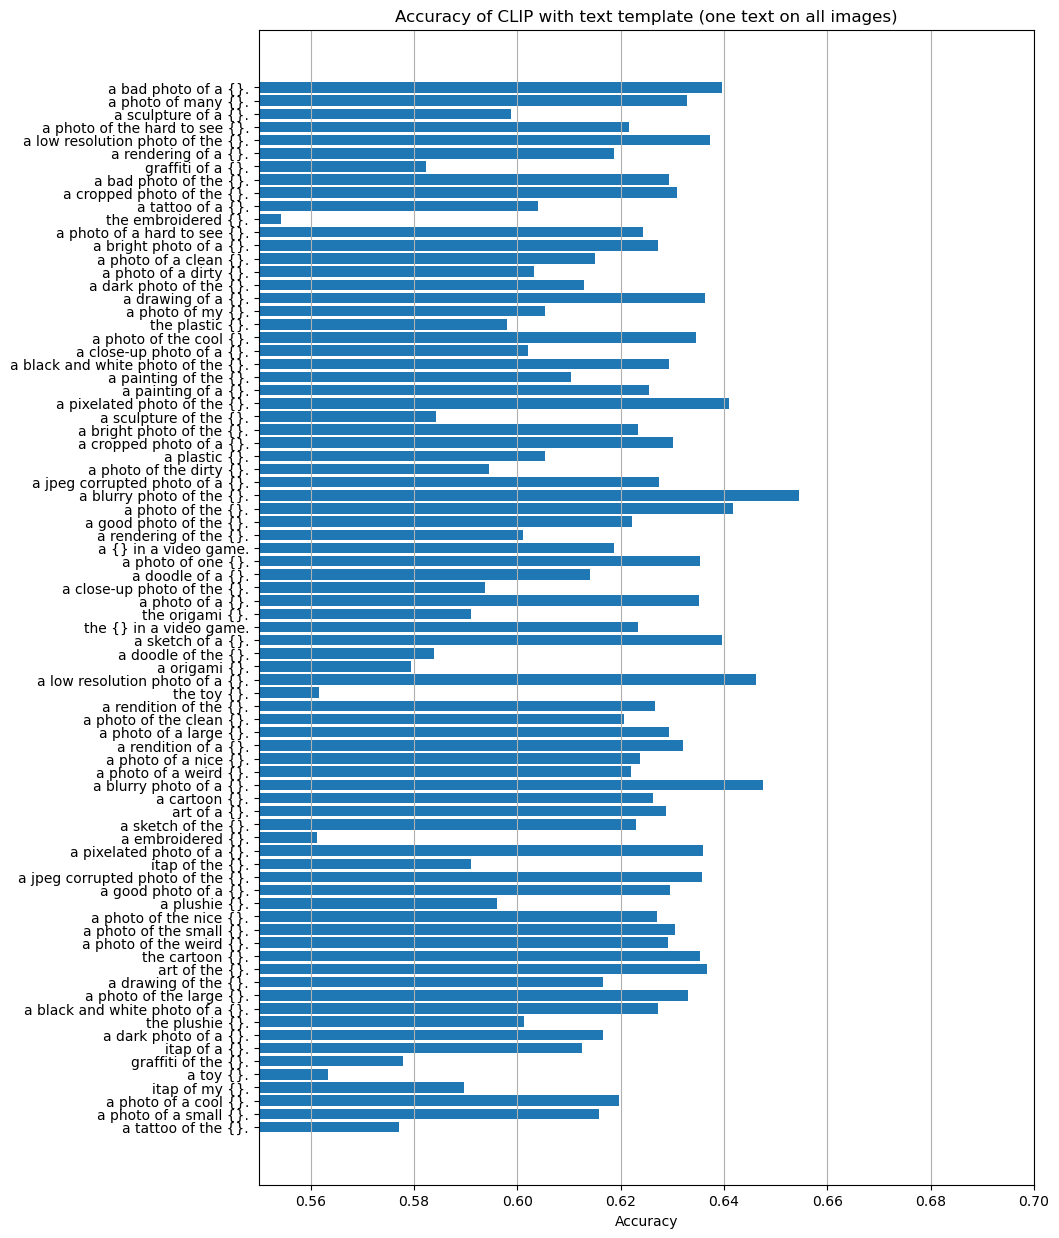

In [28]:
plt.figure(figsize=(10, 15))
plt.barh(np.arange(len(template_text_individual_acc)), template_text_individual_acc, align='center')
plt.yticks(np.arange(len(template_text_individual_acc)), imagenet_templates)
plt.xlabel('Accuracy')
plt.title('Accuracy of CLIP with text template (one text on all images)')
scale = 0.05
plt.xlim(int(template_text_individual_acc.min()/scale)*scale, (int(template_text_individual_acc.max()/scale)+1)*scale)
plt.grid(axis='x')
plt.gca().invert_yaxis()
plt.show()

In [29]:
def calc_features_similarity(features1_cuda, features2_cuda):
    with torch.no_grad():
        similarity_cuda = []
        for embeddings1 in features1_cuda:
            if type(features2_cuda) == list:  # list of tensors
                similarity_cuda.append(torch.Tensor([(embeddings1 @ embeddings2.T).mean() for embeddings2 in features2_cuda]))
            else:
                similarity_cuda.append((embeddings1 @ features2_cuda.T).mean(dim=0))

        return torch.vstack(similarity_cuda).cpu().numpy()

In [30]:
# Calculate similarity between image features and text features
img_cls_name_similarity = calc_features_similarity(img_features_cuda, cls_name_features_cuda)
img_template_cls_similarity = calc_features_similarity(img_features_cuda, template_cls_features_cuda)
img_template_text_similarity = calc_features_similarity(img_features_cuda, template_text_features_cuda)
img_original_gpt3_cls_similarity = calc_features_similarity(img_features_cuda, original_gpt3_cls_features_cuda)
img_original_gpt3_text_similarity = calc_features_similarity(img_features_cuda, original_gpt3_text_features_cuda)
img_filtered_gpt3_cls_similarity = calc_features_similarity(img_features_cuda, filtered_gpt3_cls_features_cuda)
img_filtered_gpt3_text_similarity = calc_features_similarity(img_features_cuda, filtered_gpt3_text_features_cuda)

In [31]:
def print_top_pairs(similarity, text, *, top=10, xlabel='', ylabel='', coordinates=None):
    # Get the indices of top values
    top_indices = np.unravel_index(np.argsort(-similarity, axis=None)[:top], similarity.shape)

    # Extract the class names and labels for top values
    for idx, (label1, label2) in enumerate(zip(*top_indices)):
        if coordinates is None:
            print(f'Rank {idx+1}: ({label1}){ylabel}{cls_names_sorted[label1]} - ({label2}){xlabel}{cls_names_sorted[label2]}, {text}: {similarity[label1, label2]}')
        else:
            print(f'Rank {idx+1}: ({label1}){ylabel}(coor={coordinates[label1][0]:.0f},{coordinates[label1][1]:.0f}){cls_names_sorted[label1]} - ({label2}){xlabel}(coor={coordinates[label1][0]:.0f},{coordinates[label1][1]:.0f}){cls_names_sorted[label2]}, {text}: {similarity[label1, label2]}')

In [32]:
def plot_similarity(similarity, title, xlabel=None, ylabel=None):
    plt.figure(figsize=(12, 10))
    plt.imshow(similarity)
    plt.xticks(np.arange(0, similarity.shape[0], 5))
    plt.yticks(np.arange(0, similarity.shape[1], 5))
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.colorbar()
    plt.title(title)
    plt.show()

In [33]:
def plot_cm(cm, title):
    plt.figure(figsize=(12, 10))
    plt.imshow(cm)
    plt.xticks(np.arange(0, cm.shape[0], 5))
    plt.yticks(np.arange(0, cm.shape[1], 5))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.show()

In [34]:
def visualize_auto_similarity(masked_similarity, title):
    title_similarity = title + ' Similarity'
    print(f'{title_similarity.capitalize()} mean: {np.nanmean(masked_similarity)}')
    print(f'{title_similarity.capitalize()} std: {np.nanstd(masked_similarity)}')
    print_top_pairs(np.triu(masked_similarity, k=1), 'similarity')
    plot_similarity(masked_similarity, title_similarity)

In [35]:
def visualize_cross_similarity(similarity, cm, title, xlabel='Text', ylabel='Image'):
    title_similarity = title + ' Similarity'
    print(f'{title_similarity.capitalize()} mean: {np.mean(similarity)}')
    print(f'{title_similarity.capitalize()} std: {np.std(similarity)}')
    diagonal_similarity = similarity.diagonal()
    print(f'{title_similarity.capitalize()} diagonal mean: {np.mean(diagonal_similarity)}')
    print(f'{title_similarity.capitalize()} diagonal std: {np.std(diagonal_similarity)}')
    masked_similarity = similarity.copy()
    np.fill_diagonal(masked_similarity, np.nan)
    print(f'{title_similarity.capitalize()} non-diagonal mean: {np.nanmean(masked_similarity)}')
    print(f'{title_similarity.capitalize()} non-diagonal std: {np.nanstd(masked_similarity)}')
    print(f'{title_similarity.capitalize()} diagonal mean to non-diagonal mean ratio: {np.mean(diagonal_similarity)/np.nanmean(masked_similarity)}')
    print_top_pairs(masked_similarity, 'similarity', top=20, xlabel=f'({xlabel})', ylabel=f'({ylabel})')
    plot_similarity(similarity, title_similarity, xlabel=xlabel, ylabel=ylabel)
    masked_cm = cm.copy()
    np.fill_diagonal(masked_cm, np.nan)
    print_top_pairs(masked_cm, 'error rate', top=20, xlabel=f'({xlabel})', ylabel=f'({ylabel})')
    plot_cm(cm, title + ' Confusion Matrix')

Class name similarity mean: 0.72705078125
Class name similarity std: 0.052642822265625
Rank 1: (7)Basketball - (8)Basketball_Dunk, similarity: 0.94970703125
Rank 2: (16)Boxing_Punching_Bag - (17)Boxing_Speed_Bag, similarity: 0.9306640625
Rank 3: (45)Juggling_Balls - (83)Soccer_Juggling, similarity: 0.9296875
Rank 4: (39)High_Jump - (50)Long_Jump, similarity: 0.92822265625
Rank 5: (22)Cricket_Bowling - (23)Cricket_Shot, similarity: 0.92041015625
Rank 6: (28)Field_Hockey_Penalty - (84)Soccer_Penalty, similarity: 0.916015625
Rank 7: (40)Horse_Race - (41)Horse_Riding, similarity: 0.91259765625
Rank 8: (36)Handstand_Pushups - (37)Handstand_Walking, similarity: 0.9072265625
Rank 9: (0)Apply_Eye_Makeup - (1)Apply_Lipstick, similarity: 0.90673828125
Rank 10: (15)Bowling - (22)Cricket_Bowling, similarity: 0.90283203125


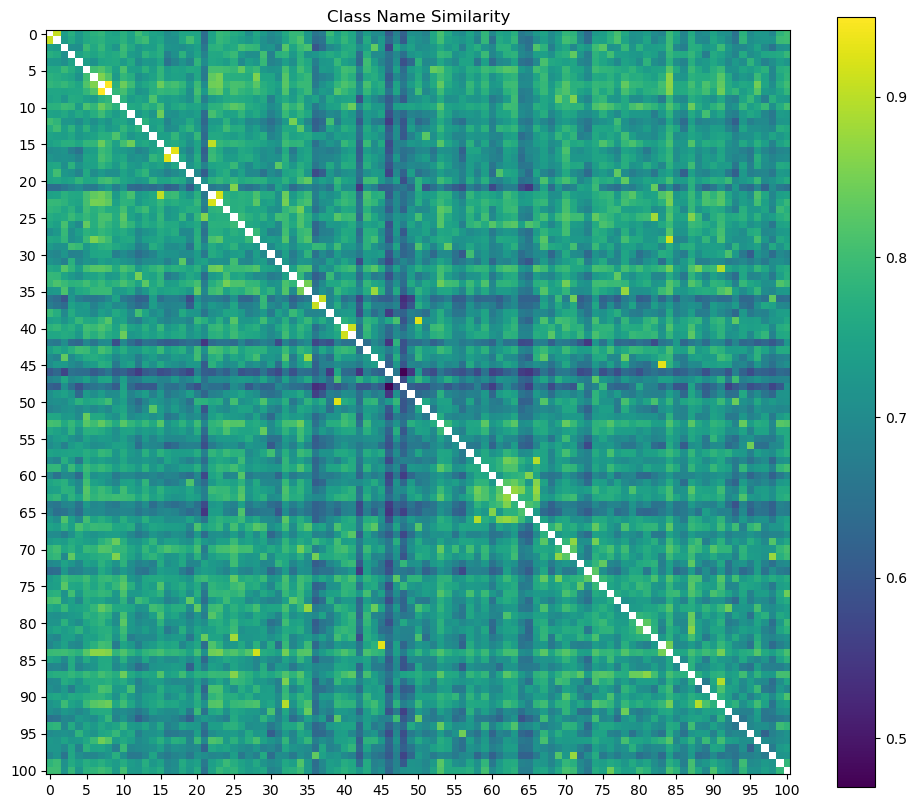

Text template similarity mean: 0.71337890625
Text template similarity std: 0.05523681640625
Rank 1: (39)High_Jump - (50)Long_Jump, similarity: 0.95068359375
Rank 2: (7)Basketball - (8)Basketball_Dunk, similarity: 0.9501953125
Rank 3: (15)Bowling - (22)Cricket_Bowling, similarity: 0.93408203125
Rank 4: (36)Handstand_Pushups - (37)Handstand_Walking, similarity: 0.9267578125
Rank 5: (40)Horse_Race - (41)Horse_Riding, similarity: 0.92431640625
Rank 6: (16)Boxing_Punching_Bag - (17)Boxing_Speed_Bag, similarity: 0.92431640625
Rank 7: (28)Field_Hockey_Penalty - (84)Soccer_Penalty, similarity: 0.92138671875
Rank 8: (45)Juggling_Balls - (83)Soccer_Juggling, similarity: 0.91552734375
Rank 9: (22)Cricket_Bowling - (23)Cricket_Shot, similarity: 0.90625
Rank 10: (58)Playing_Cello - (66)Playing_Violin, similarity: 0.89892578125


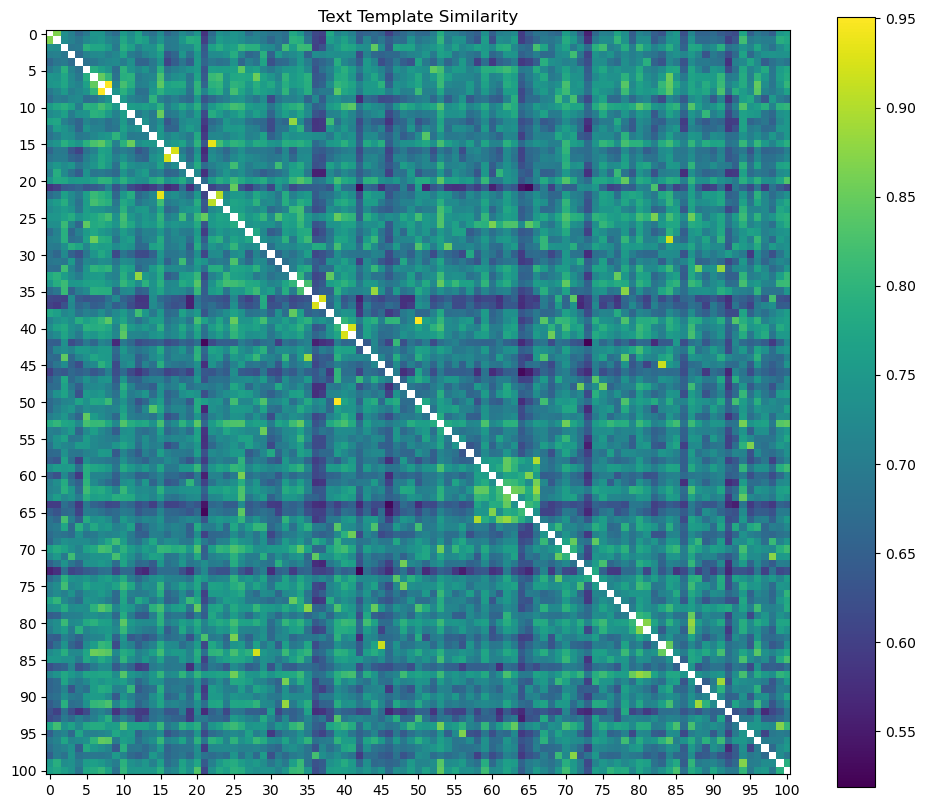

Original gpt-3 text similarity mean: 0.744140625
Original gpt-3 text similarity std: 0.056549072265625
Rank 1: (18)Breast_Stroke - (31)Front_Crawl, similarity: 0.96142578125
Rank 2: (7)Basketball - (8)Basketball_Dunk, similarity: 0.95361328125
Rank 3: (16)Boxing_Punching_Bag - (17)Boxing_Speed_Bag, similarity: 0.951171875
Rank 4: (36)Handstand_Pushups - (37)Handstand_Walking, similarity: 0.9501953125
Rank 5: (39)High_Jump - (50)Long_Jump, similarity: 0.9443359375
Rank 6: (22)Cricket_Bowling - (23)Cricket_Shot, similarity: 0.9404296875
Rank 7: (40)Horse_Race - (41)Horse_Riding, similarity: 0.93798828125
Rank 8: (56)Parallel_Bars - (95)Uneven_Bars, similarity: 0.931640625
Rank 9: (28)Field_Hockey_Penalty - (84)Soccer_Penalty, similarity: 0.93017578125
Rank 10: (32)Golf_Swing - (91)Tennis_Swing, similarity: 0.9208984375


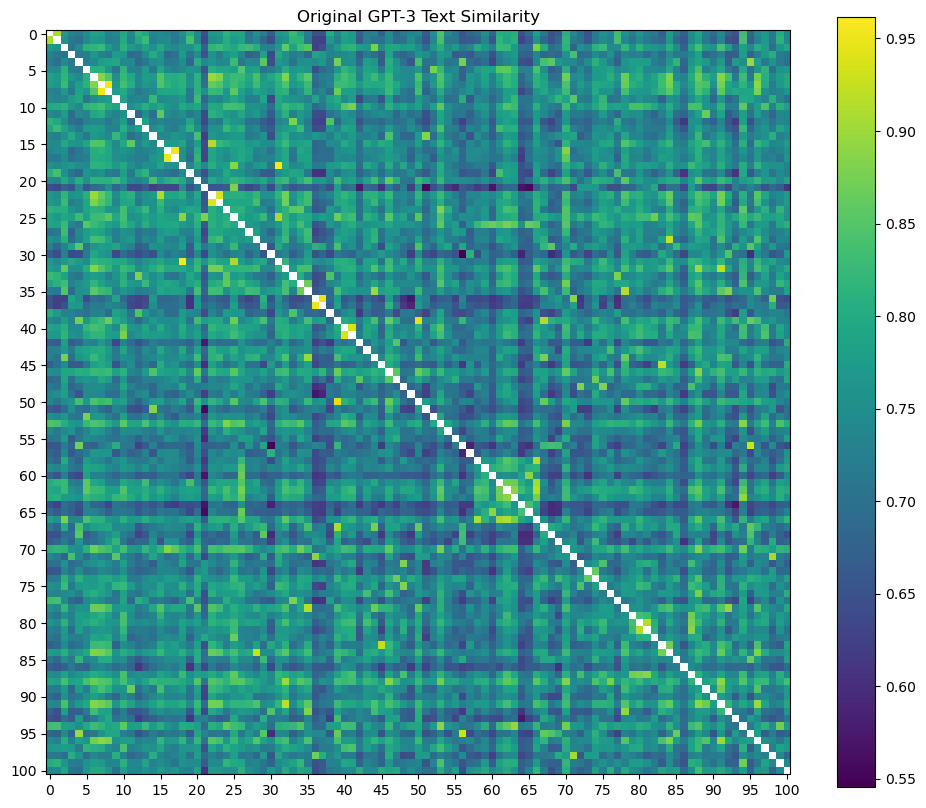

Filtered gpt-3 text similarity mean: 0.7412109375
Filtered gpt-3 text similarity std: 0.057952880859375
Rank 1: (18)Breast_Stroke - (31)Front_Crawl, similarity: 0.96142578125
Rank 2: (7)Basketball - (8)Basketball_Dunk, similarity: 0.95361328125
Rank 3: (36)Handstand_Pushups - (37)Handstand_Walking, similarity: 0.951171875
Rank 4: (16)Boxing_Punching_Bag - (17)Boxing_Speed_Bag, similarity: 0.94873046875
Rank 5: (22)Cricket_Bowling - (23)Cricket_Shot, similarity: 0.94677734375
Rank 6: (39)High_Jump - (50)Long_Jump, similarity: 0.94287109375
Rank 7: (40)Horse_Race - (41)Horse_Riding, similarity: 0.9384765625
Rank 8: (28)Field_Hockey_Penalty - (84)Soccer_Penalty, similarity: 0.9306640625
Rank 9: (56)Parallel_Bars - (95)Uneven_Bars, similarity: 0.93017578125
Rank 10: (32)Golf_Swing - (91)Tennis_Swing, similarity: 0.9228515625


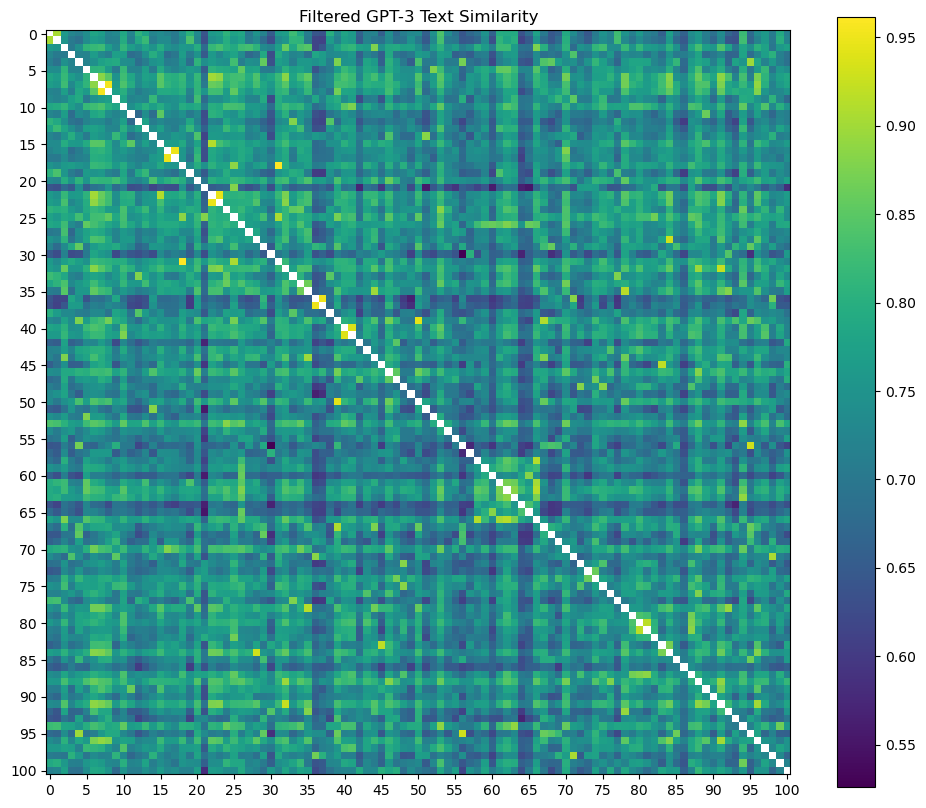

In [36]:
# Auto-similarity of text features
visualize_auto_similarity(cls_name_masked_similarity, 'Class Name')
visualize_auto_similarity(template_masked_similarity, 'Text Template')
visualize_auto_similarity(original_gpt3_masked_similarity, 'Original GPT-3 Text')
visualize_auto_similarity(filtered_gpt3_masked_similarity, 'Filtered GPT-3 Text')

Image similarity mean: 0.7294921875
Image similarity std: 0.0853271484375
Rank 1: (18)Breast_Stroke - (31)Front_Crawl, similarity: 0.97314453125
Rank 2: (39)High_Jump - (44)Javelin_Throw, similarity: 0.9697265625
Rank 3: (4)Balance_Beam - (56)Parallel_Bars, similarity: 0.962890625
Rank 4: (4)Balance_Beam - (29)Floor_Gymnastics, similarity: 0.96240234375
Rank 5: (88)Swing - (93)Trampoline_Jumping, similarity: 0.96044921875
Rank 6: (39)High_Jump - (50)Long_Jump, similarity: 0.958984375
Rank 7: (18)Breast_Stroke - (25)Diving, similarity: 0.95751953125
Rank 8: (78)Shotput - (92)Throw_Discus, similarity: 0.95703125
Rank 9: (12)Blow_Dry_Hair - (33)Haircut, similarity: 0.953125
Rank 10: (44)Javelin_Throw - (50)Long_Jump, similarity: 0.951171875


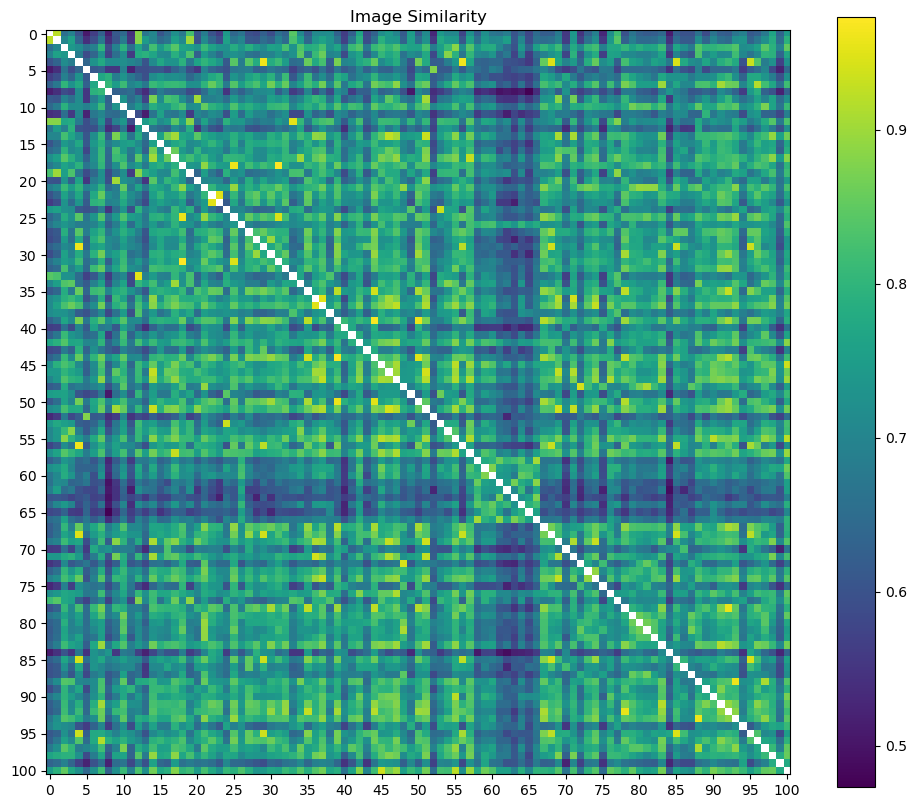

Image to class name similarity mean: 0.208984375
Image to class name similarity std: 0.030303955078125
Image to class name similarity diagonal mean: 0.2939453125
Image to class name similarity diagonal std: 0.0274810791015625
Image to class name similarity non-diagonal mean: 0.2081298828125
Image to class name similarity non-diagonal std: 0.0290985107421875
Image to class name similarity diagonal mean to non-diagonal mean ratio: 1.412109375
Rank 1: (92)(Image)Throw_Discus - (35)(Text)Hammer_Throw, similarity: 0.32470703125
Rank 2: (60)(Image)Playing_Dhol - (65)(Text)Playing_Tabla, similarity: 0.323974609375
Rank 3: (16)(Image)Boxing_Punching_Bag - (17)(Text)Boxing_Speed_Bag, similarity: 0.3232421875
Rank 4: (35)(Image)Hammer_Throw - (44)(Text)Javelin_Throw, similarity: 0.322021484375
Rank 5: (78)(Image)Shotput - (35)(Text)Hammer_Throw, similarity: 0.321533203125
Rank 6: (36)(Image)Handstand_Pushups - (37)(Text)Handstand_Walking, similarity: 0.3203125
Rank 7: (56)(Image)Parallel_Bars - 

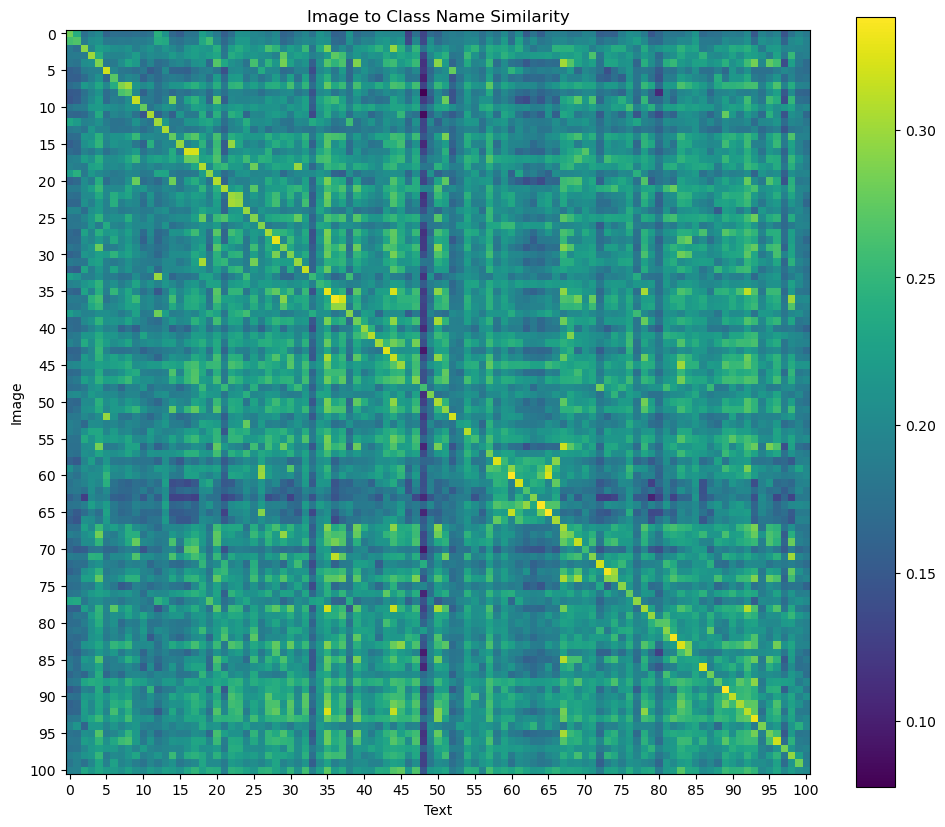

Rank 1: (33)(Image)Haircut - (12)(Text)Blow_Dry_Hair, error rate: 0.9393939393939394
Rank 2: (53)(Image)Mixing - (24)(Text)Cutting_In_Kitchen, error rate: 0.9333333333333333
Rank 3: (71)(Image)Push_Ups - (36)(Text)Handstand_Pushups, error rate: 0.9
Rank 4: (70)(Image)Punch - (17)(Text)Boxing_Speed_Bag, error rate: 0.8974358974358975
Rank 5: (56)(Image)Parallel_Bars - (67)(Text)Pole_Vault, error rate: 0.8648648648648649
Rank 6: (7)(Image)Basketball - (8)(Text)Basketball_Dunk, error rate: 0.8285714285714286
Rank 7: (95)(Image)Uneven_Bars - (67)(Text)Pole_Vault, error rate: 0.7857142857142857
Rank 8: (31)(Image)Front_Crawl - (18)(Text)Breast_Stroke, error rate: 0.7567567567567568
Rank 9: (85)(Image)Still_Rings - (67)(Text)Pole_Vault, error rate: 0.75
Rank 10: (92)(Image)Throw_Discus - (35)(Text)Hammer_Throw, error rate: 0.7368421052631579
Rank 11: (48)(Image)Kayaking - (72)(Text)Rafting, error rate: 0.6666666666666666
Rank 12: (39)(Image)High_Jump - (50)(Text)Long_Jump, error rate: 0.5945

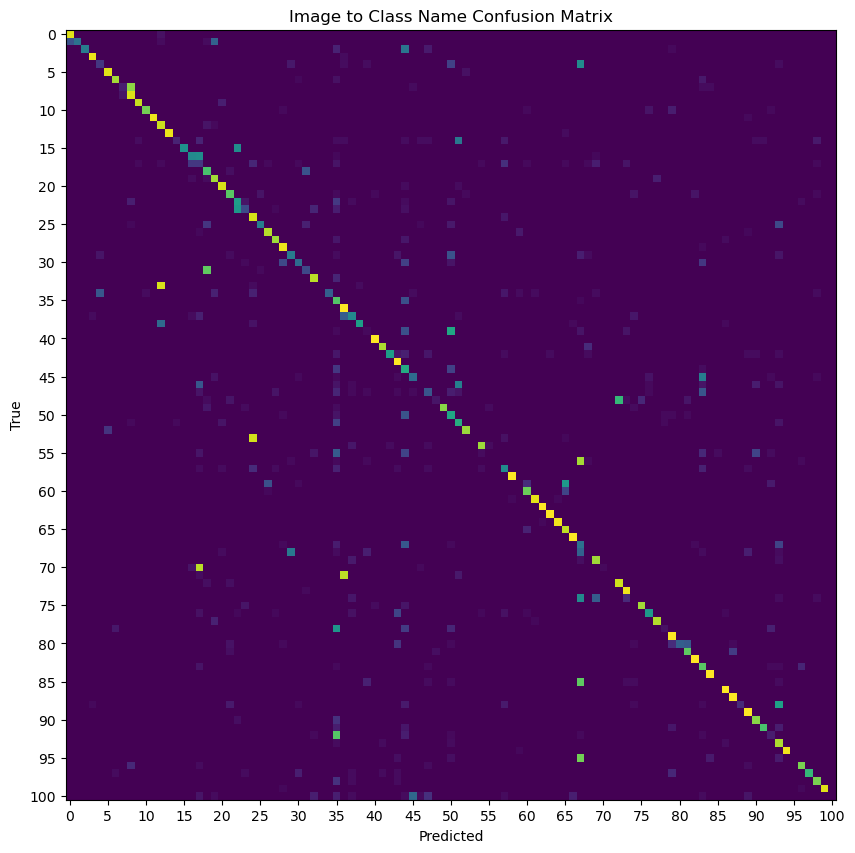

Image to text template (centroid) similarity mean: 0.2000732421875
Image to text template (centroid) similarity std: 0.031585693359375
Image to text template (centroid) similarity diagonal mean: 0.294921875
Image to text template (centroid) similarity diagonal std: 0.02569580078125
Image to text template (centroid) similarity non-diagonal mean: 0.1990966796875
Image to text template (centroid) similarity non-diagonal std: 0.0301666259765625
Image to text template (centroid) similarity diagonal mean to non-diagonal mean ratio: 1.4814453125
Rank 1: (36)(Image)Handstand_Pushups - (37)(Text)Handstand_Walking, similarity: 0.32763671875
Rank 2: (65)(Image)Playing_Tabla - (60)(Text)Playing_Dhol, similarity: 0.326904296875
Rank 3: (16)(Image)Boxing_Punching_Bag - (17)(Text)Boxing_Speed_Bag, similarity: 0.32421875
Rank 4: (60)(Image)Playing_Dhol - (65)(Text)Playing_Tabla, similarity: 0.323974609375
Rank 5: (59)(Image)Playing_Daf - (65)(Text)Playing_Tabla, similarity: 0.320068359375
Rank 6: (92)

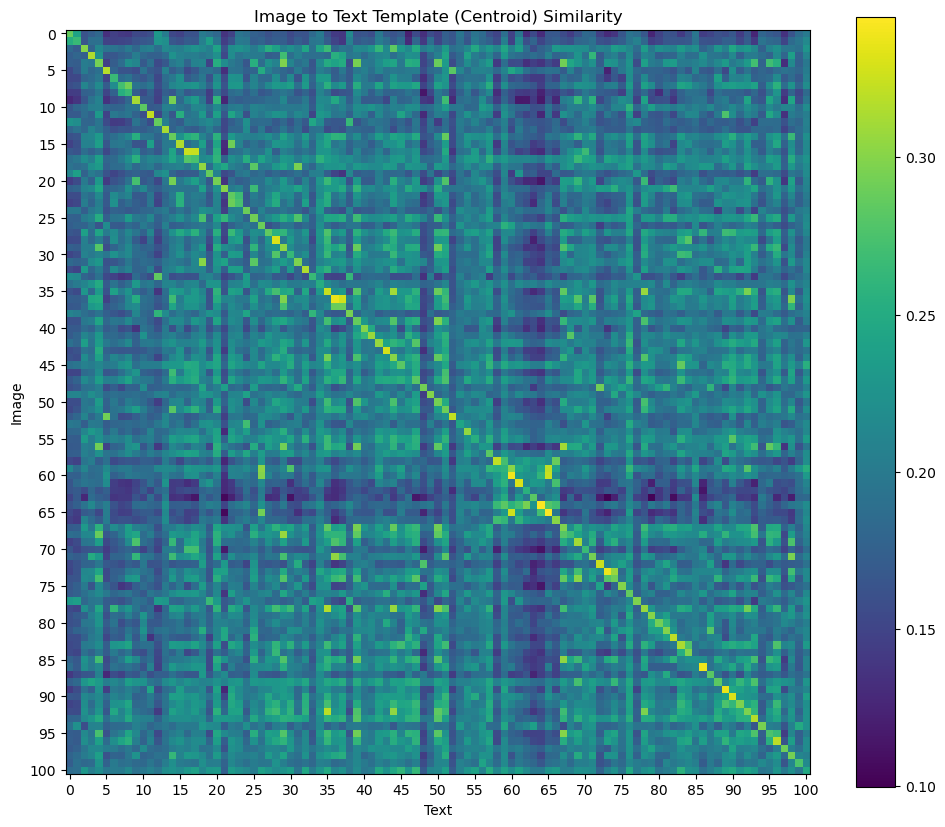

Rank 1: (7)(Image)Basketball - (8)(Text)Basketball_Dunk, error rate: 0.8857142857142857
Rank 2: (33)(Image)Haircut - (12)(Text)Blow_Dry_Hair, error rate: 0.8787878787878788
Rank 3: (53)(Image)Mixing - (24)(Text)Cutting_In_Kitchen, error rate: 0.8444444444444444
Rank 4: (92)(Image)Throw_Discus - (35)(Text)Hammer_Throw, error rate: 0.7368421052631579
Rank 5: (23)(Image)Cricket_Shot - (22)(Text)Cricket_Bowling, error rate: 0.7142857142857143
Rank 6: (39)(Image)High_Jump - (50)(Text)Long_Jump, error rate: 0.7027027027027027
Rank 7: (56)(Image)Parallel_Bars - (67)(Text)Pole_Vault, error rate: 0.6756756756756757
Rank 8: (31)(Image)Front_Crawl - (18)(Text)Breast_Stroke, error rate: 0.6216216216216216
Rank 9: (71)(Image)Push_Ups - (36)(Text)Handstand_Pushups, error rate: 0.5666666666666667
Rank 10: (30)(Image)Frisbee_Catch - (28)(Text)Field_Hockey_Penalty, error rate: 0.5405405405405406
Rank 11: (59)(Image)Playing_Daf - (65)(Text)Playing_Tabla, error rate: 0.5365853658536586
Rank 12: (85)(Imag

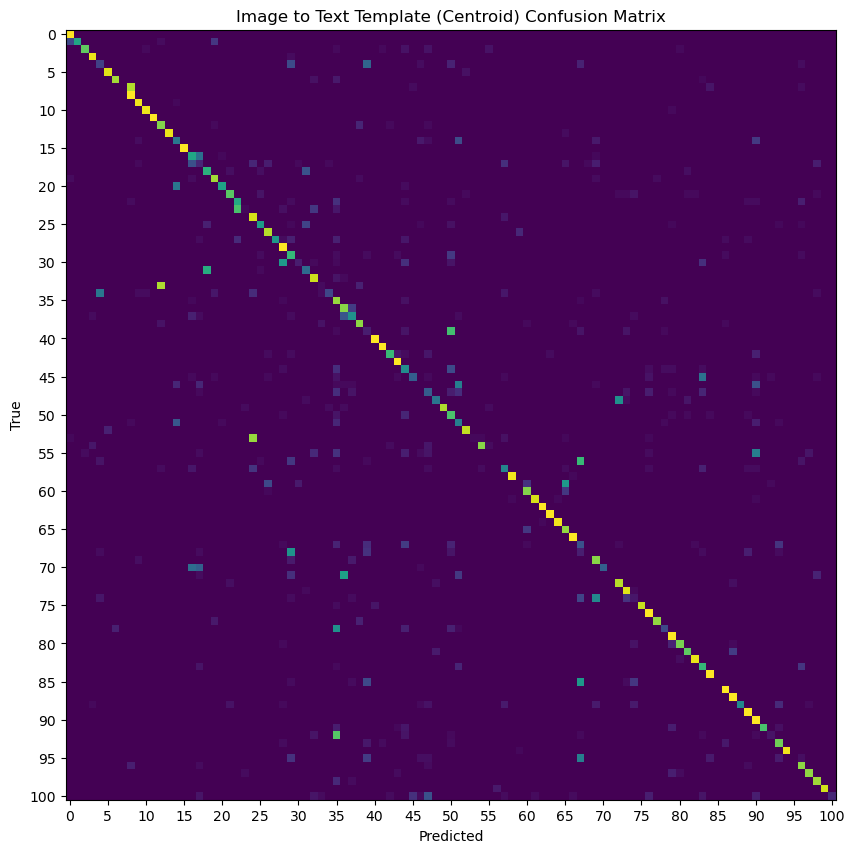

Image to text template (individual avg) similarity mean: 0.1843232363462448
Image to text template (individual avg) similarity std: 0.029197297990322113
Image to text template (individual avg) similarity diagonal mean: 0.27166566252708435
Image to text template (individual avg) similarity diagonal std: 0.02410566620528698
Image to text template (individual avg) similarity non-diagonal mean: 0.18344980478286743
Image to text template (individual avg) similarity non-diagonal std: 0.02789527364075184
Image to text template (individual avg) similarity diagonal mean to non-diagonal mean ratio: 1.4808719158172607
Rank 1: (36)(Image)Handstand_Pushups - (37)(Text)Handstand_Walking, similarity: 0.303955078125
Rank 2: (65)(Image)Playing_Tabla - (60)(Text)Playing_Dhol, similarity: 0.301025390625
Rank 3: (60)(Image)Playing_Dhol - (65)(Text)Playing_Tabla, similarity: 0.299072265625
Rank 4: (16)(Image)Boxing_Punching_Bag - (17)(Text)Boxing_Speed_Bag, similarity: 0.299072265625
Rank 5: (59)(Image)Pla

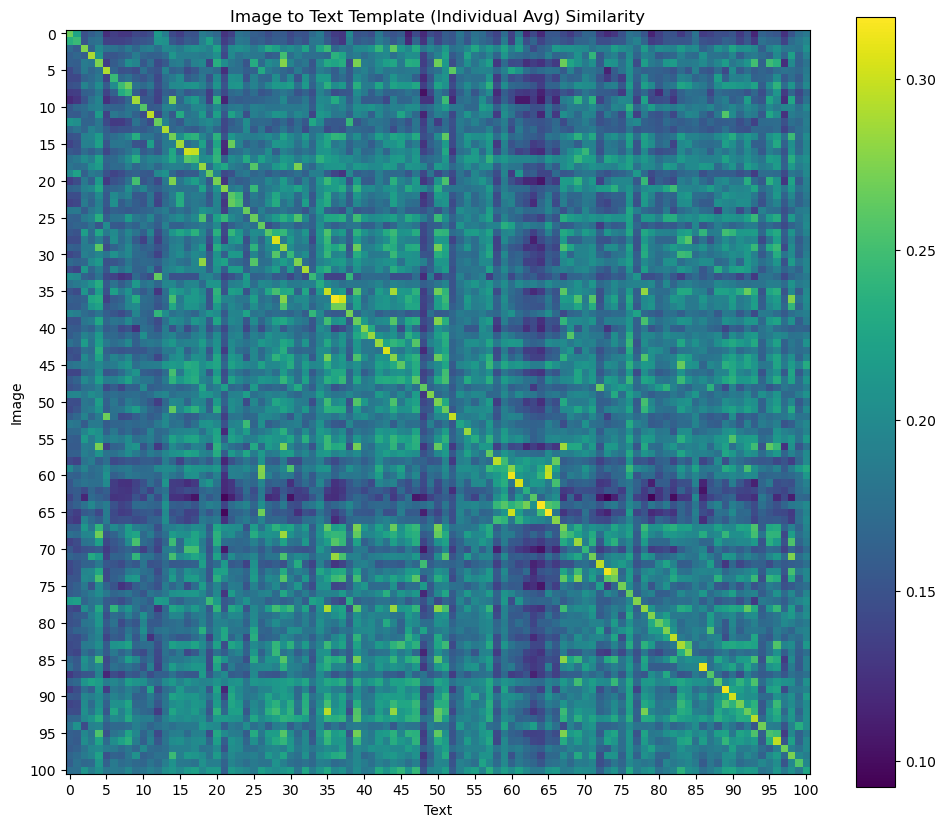

Rank 1: (7)(Image)Basketball - (8)(Text)Basketball_Dunk, error rate: 0.8857142857142857
Rank 2: (33)(Image)Haircut - (12)(Text)Blow_Dry_Hair, error rate: 0.8484848484848485
Rank 3: (53)(Image)Mixing - (24)(Text)Cutting_In_Kitchen, error rate: 0.8
Rank 4: (92)(Image)Throw_Discus - (35)(Text)Hammer_Throw, error rate: 0.7631578947368421
Rank 5: (39)(Image)High_Jump - (50)(Text)Long_Jump, error rate: 0.7567567567567568
Rank 6: (31)(Image)Front_Crawl - (18)(Text)Breast_Stroke, error rate: 0.7027027027027027
Rank 7: (71)(Image)Push_Ups - (36)(Text)Handstand_Pushups, error rate: 0.7
Rank 8: (23)(Image)Cricket_Shot - (22)(Text)Cricket_Bowling, error rate: 0.6938775510204082
Rank 9: (56)(Image)Parallel_Bars - (67)(Text)Pole_Vault, error rate: 0.5945945945945946
Rank 10: (59)(Image)Playing_Daf - (65)(Text)Playing_Tabla, error rate: 0.5853658536585366
Rank 11: (48)(Image)Kayaking - (72)(Text)Rafting, error rate: 0.5555555555555556
Rank 12: (30)(Image)Frisbee_Catch - (28)(Text)Field_Hockey_Penalty

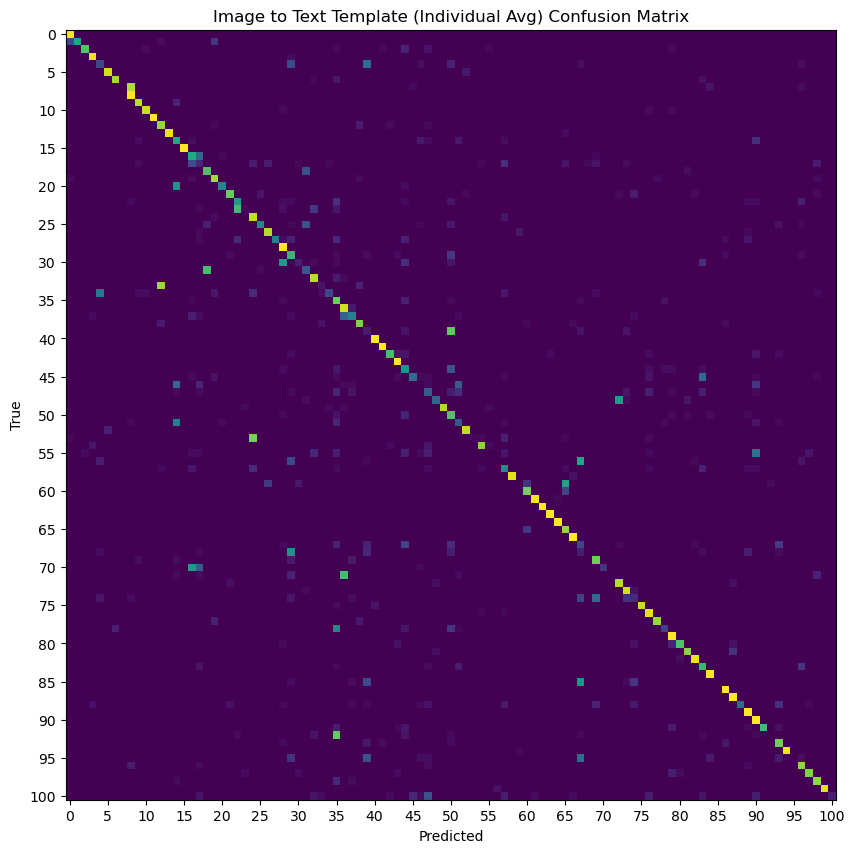

Image to original gpt-3 text (centroid) similarity mean: 0.2032470703125
Image to original gpt-3 text (centroid) similarity std: 0.032501220703125
Image to original gpt-3 text (centroid) similarity diagonal mean: 0.30517578125
Image to original gpt-3 text (centroid) similarity diagonal std: 0.0189971923828125
Image to original gpt-3 text (centroid) similarity non-diagonal mean: 0.2021484375
Image to original gpt-3 text (centroid) similarity non-diagonal std: 0.0309295654296875
Image to original gpt-3 text (centroid) similarity diagonal mean to non-diagonal mean ratio: 1.509765625
Rank 1: (36)(Image)Handstand_Pushups - (37)(Text)Handstand_Walking, similarity: 0.33154296875
Rank 2: (16)(Image)Boxing_Punching_Bag - (17)(Text)Boxing_Speed_Bag, similarity: 0.328857421875
Rank 3: (35)(Image)Hammer_Throw - (92)(Text)Throw_Discus, similarity: 0.32568359375
Rank 4: (65)(Image)Playing_Tabla - (60)(Text)Playing_Dhol, similarity: 0.32421875
Rank 5: (92)(Image)Throw_Discus - (35)(Text)Hammer_Throw,

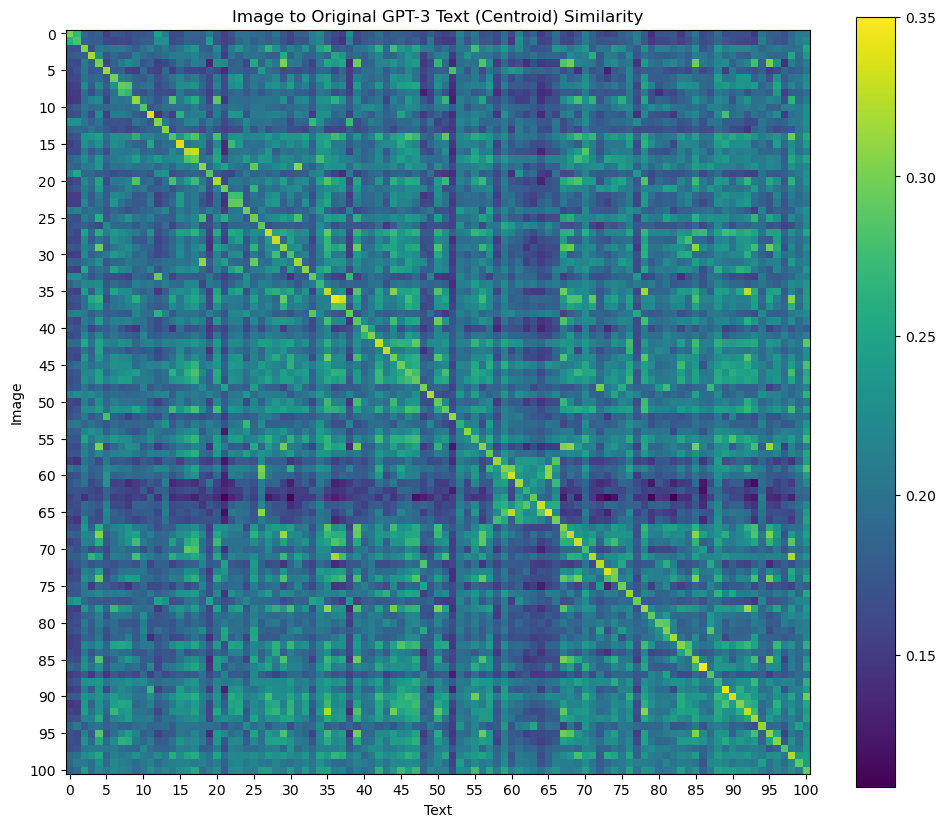

Rank 1: (8)(Image)Basketball_Dunk - (7)(Text)Basketball, error rate: 0.8918918918918919
Rank 2: (70)(Image)Punch - (16)(Text)Boxing_Punching_Bag, error rate: 0.8205128205128205
Rank 3: (16)(Image)Boxing_Punching_Bag - (17)(Text)Boxing_Speed_Bag, error rate: 0.6326530612244898
Rank 4: (53)(Image)Mixing - (24)(Text)Cutting_In_Kitchen, error rate: 0.6222222222222222
Rank 5: (35)(Image)Hammer_Throw - (92)(Text)Throw_Discus, error rate: 0.5555555555555556
Rank 6: (39)(Image)High_Jump - (50)(Text)Long_Jump, error rate: 0.5405405405405406
Rank 7: (18)(Image)Breast_Stroke - (31)(Text)Front_Crawl, error rate: 0.5357142857142857
Rank 8: (78)(Image)Shotput - (92)(Text)Throw_Discus, error rate: 0.4782608695652174
Rank 9: (48)(Image)Kayaking - (72)(Text)Rafting, error rate: 0.4444444444444444
Rank 10: (37)(Image)Handstand_Walking - (36)(Text)Handstand_Pushups, error rate: 0.4117647058823529
Rank 11: (23)(Image)Cricket_Shot - (22)(Text)Cricket_Bowling, error rate: 0.40816326530612246
Rank 12: (33)(I

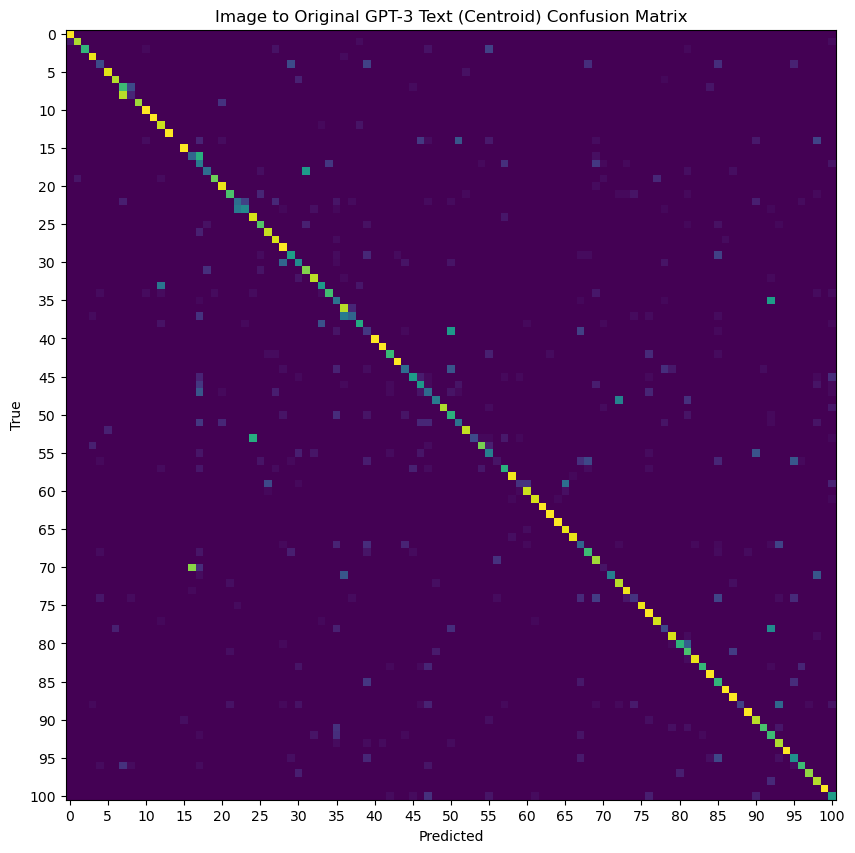

Image to original gpt-3 text (individual avg) similarity mean: 0.1909959316253662
Image to original gpt-3 text (individual avg) similarity std: 0.030202943831682205
Image to original gpt-3 text (individual avg) similarity diagonal mean: 0.2868615984916687
Image to original gpt-3 text (individual avg) similarity diagonal std: 0.01875114068388939
Image to original gpt-3 text (individual avg) similarity non-diagonal mean: 0.19003728032112122
Image to original gpt-3 text (individual avg) similarity non-diagonal std: 0.028722859919071198
Image to original gpt-3 text (individual avg) similarity diagonal mean to non-diagonal mean ratio: 1.5095016956329346
Rank 1: (36)(Image)Handstand_Pushups - (37)(Text)Handstand_Walking, similarity: 0.31591796875
Rank 2: (16)(Image)Boxing_Punching_Bag - (17)(Text)Boxing_Speed_Bag, similarity: 0.306640625
Rank 3: (35)(Image)Hammer_Throw - (92)(Text)Throw_Discus, similarity: 0.303955078125
Rank 4: (92)(Image)Throw_Discus - (35)(Text)Hammer_Throw, similarity: 0

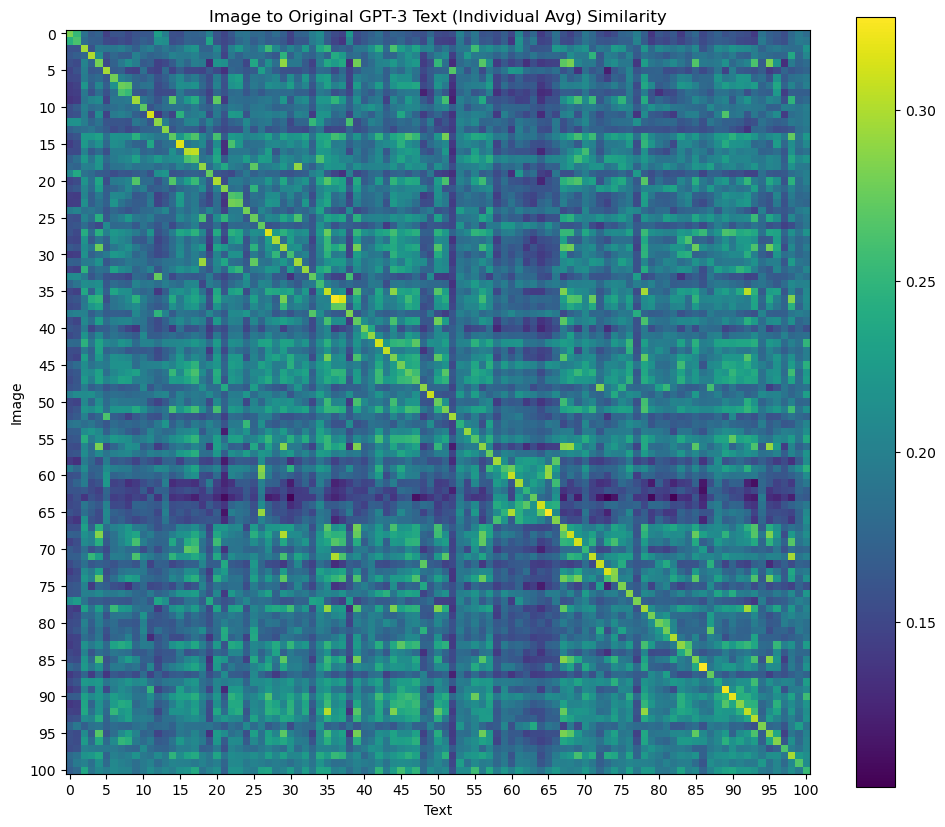

Rank 1: (8)(Image)Basketball_Dunk - (7)(Text)Basketball, error rate: 0.918918918918919
Rank 2: (70)(Image)Punch - (16)(Text)Boxing_Punching_Bag, error rate: 0.8717948717948718
Rank 3: (16)(Image)Boxing_Punching_Bag - (17)(Text)Boxing_Speed_Bag, error rate: 0.6326530612244898
Rank 4: (53)(Image)Mixing - (24)(Text)Cutting_In_Kitchen, error rate: 0.6222222222222222
Rank 5: (23)(Image)Cricket_Shot - (22)(Text)Cricket_Bowling, error rate: 0.5306122448979592
Rank 6: (4)(Image)Balance_Beam - (29)(Text)Floor_Gymnastics, error rate: 0.5161290322580645
Rank 7: (88)(Image)Swing - (93)(Text)Trampoline_Jumping, error rate: 0.5
Rank 8: (39)(Image)High_Jump - (50)(Text)Long_Jump, error rate: 0.4594594594594595
Rank 9: (59)(Image)Playing_Daf - (65)(Text)Playing_Tabla, error rate: 0.43902439024390244
Rank 10: (14)(Image)Body_Weight_Squats - (51)(Text)Lunges, error rate: 0.43333333333333335
Rank 11: (48)(Image)Kayaking - (72)(Text)Rafting, error rate: 0.4166666666666667
Rank 12: (78)(Image)Shotput - (92

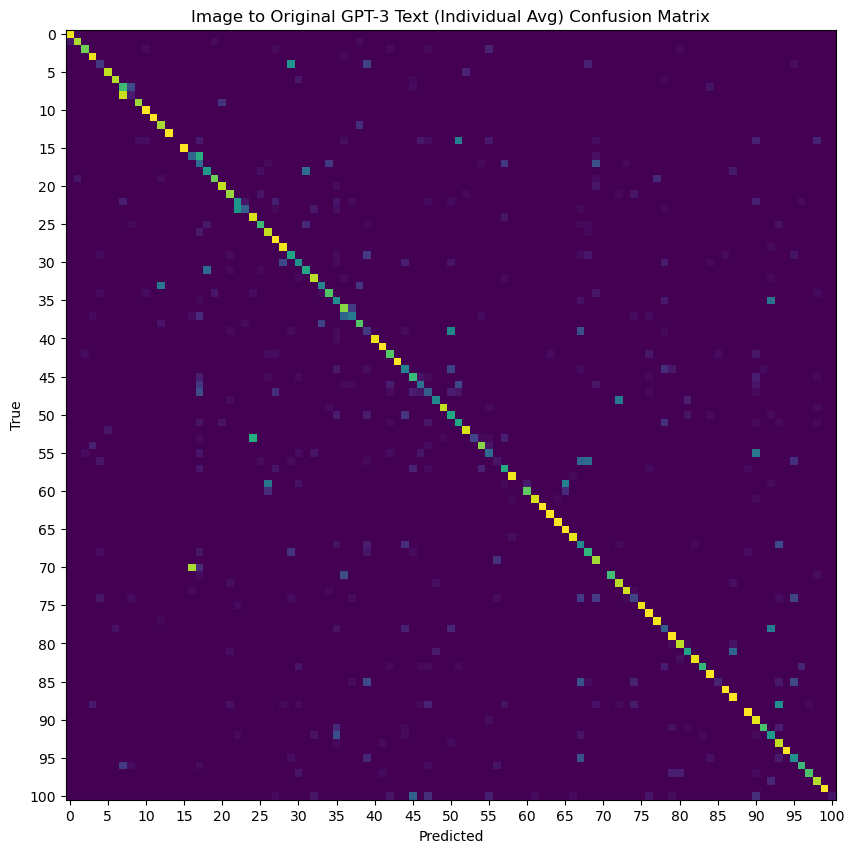

Image to filtered gpt-3 text (centroid) similarity mean: 0.2027587890625
Image to filtered gpt-3 text (centroid) similarity std: 0.032684326171875
Image to filtered gpt-3 text (centroid) similarity diagonal mean: 0.30517578125
Image to filtered gpt-3 text (centroid) similarity diagonal std: 0.018951416015625
Image to filtered gpt-3 text (centroid) similarity non-diagonal mean: 0.20166015625
Image to filtered gpt-3 text (centroid) similarity non-diagonal std: 0.0311431884765625
Image to filtered gpt-3 text (centroid) similarity diagonal mean to non-diagonal mean ratio: 1.513671875
Rank 1: (36)(Image)Handstand_Pushups - (37)(Text)Handstand_Walking, similarity: 0.3330078125
Rank 2: (16)(Image)Boxing_Punching_Bag - (17)(Text)Boxing_Speed_Bag, similarity: 0.32861328125
Rank 3: (35)(Image)Hammer_Throw - (92)(Text)Throw_Discus, similarity: 0.32568359375
Rank 4: (65)(Image)Playing_Tabla - (60)(Text)Playing_Dhol, similarity: 0.32568359375
Rank 5: (92)(Image)Throw_Discus - (35)(Text)Hammer_Throw

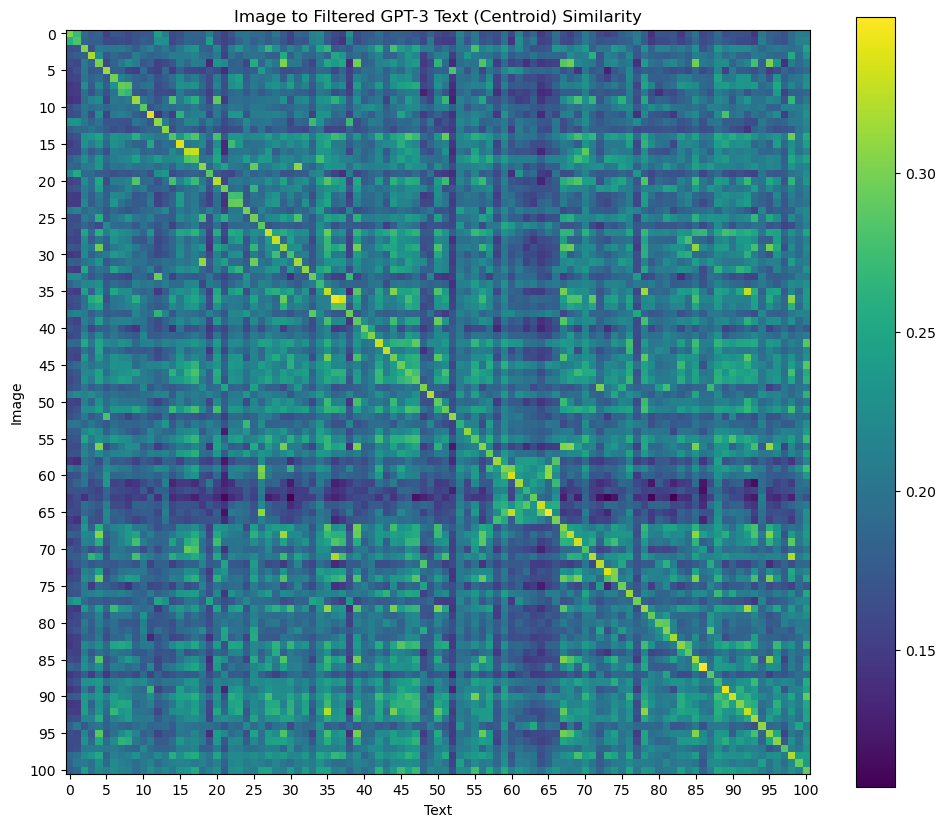

Rank 1: (8)(Image)Basketball_Dunk - (7)(Text)Basketball, error rate: 0.8918918918918919
Rank 2: (70)(Image)Punch - (16)(Text)Boxing_Punching_Bag, error rate: 0.8461538461538461
Rank 3: (53)(Image)Mixing - (24)(Text)Cutting_In_Kitchen, error rate: 0.6222222222222222
Rank 4: (16)(Image)Boxing_Punching_Bag - (17)(Text)Boxing_Speed_Bag, error rate: 0.5510204081632653
Rank 5: (18)(Image)Breast_Stroke - (31)(Text)Front_Crawl, error rate: 0.5357142857142857
Rank 6: (35)(Image)Hammer_Throw - (92)(Text)Throw_Discus, error rate: 0.5333333333333333
Rank 7: (78)(Image)Shotput - (92)(Text)Throw_Discus, error rate: 0.5
Rank 8: (39)(Image)High_Jump - (50)(Text)Long_Jump, error rate: 0.4594594594594595
Rank 9: (48)(Image)Kayaking - (72)(Text)Rafting, error rate: 0.4444444444444444
Rank 10: (37)(Image)Handstand_Walking - (36)(Text)Handstand_Pushups, error rate: 0.4117647058823529
Rank 11: (33)(Image)Haircut - (12)(Text)Blow_Dry_Hair, error rate: 0.3939393939393939
Rank 12: (23)(Image)Cricket_Shot - (22

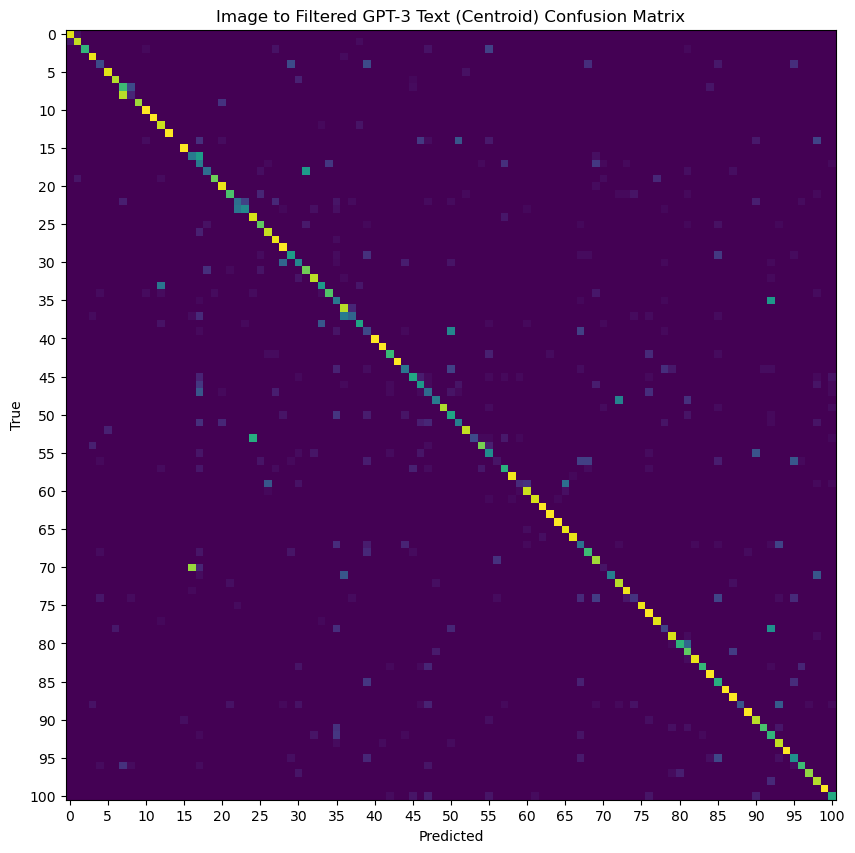

Image to filtered gpt-3 text (individual avg) similarity mean: 0.19108206033706665
Image to filtered gpt-3 text (individual avg) similarity std: 0.030557043850421906
Image to filtered gpt-3 text (individual avg) similarity diagonal mean: 0.2878563106060028
Image to filtered gpt-3 text (individual avg) similarity diagonal std: 0.01833975687623024
Image to filtered gpt-3 text (individual avg) similarity non-diagonal mean: 0.19011430442333221
Image to filtered gpt-3 text (individual avg) similarity non-diagonal std: 0.029070908203721046
Image to filtered gpt-3 text (individual avg) similarity diagonal mean to non-diagonal mean ratio: 1.5141223669052124
Rank 1: (36)(Image)Handstand_Pushups - (37)(Text)Handstand_Walking, similarity: 0.318359375
Rank 2: (16)(Image)Boxing_Punching_Bag - (17)(Text)Boxing_Speed_Bag, similarity: 0.307861328125
Rank 3: (65)(Image)Playing_Tabla - (60)(Text)Playing_Dhol, similarity: 0.3046875
Rank 4: (92)(Image)Throw_Discus - (35)(Text)Hammer_Throw, similarity: 0.3

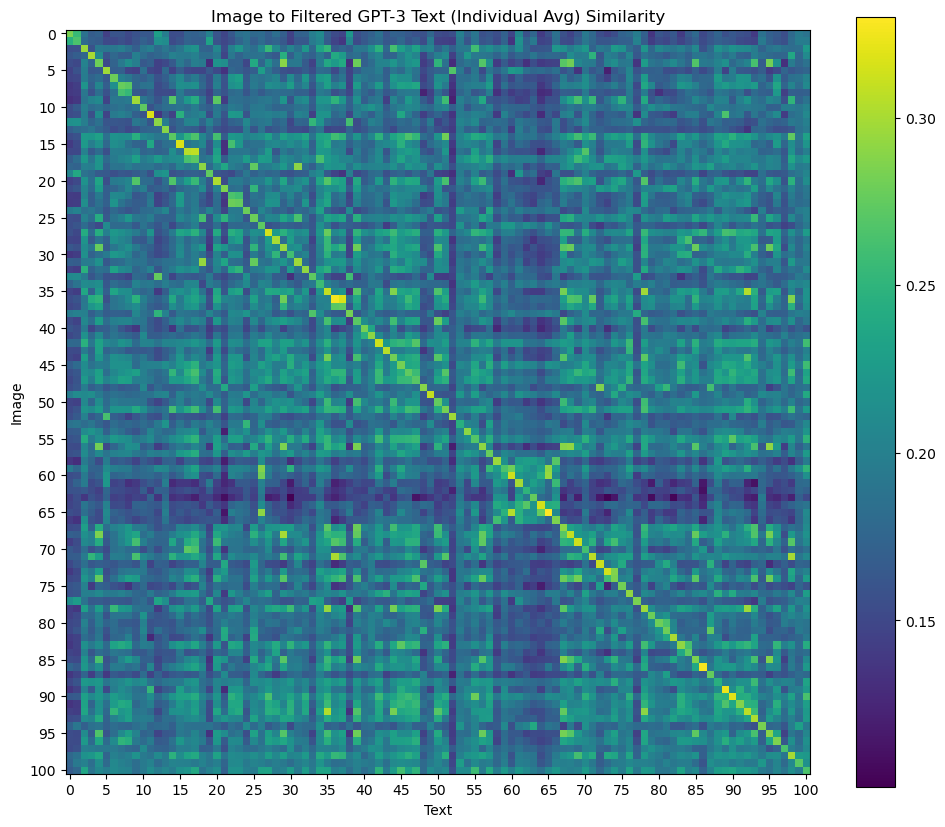

Rank 1: (8)(Image)Basketball_Dunk - (7)(Text)Basketball, error rate: 0.918918918918919
Rank 2: (70)(Image)Punch - (16)(Text)Boxing_Punching_Bag, error rate: 0.8461538461538461
Rank 3: (53)(Image)Mixing - (24)(Text)Cutting_In_Kitchen, error rate: 0.6
Rank 4: (23)(Image)Cricket_Shot - (22)(Text)Cricket_Bowling, error rate: 0.5714285714285714
Rank 5: (16)(Image)Boxing_Punching_Bag - (17)(Text)Boxing_Speed_Bag, error rate: 0.5510204081632653
Rank 6: (4)(Image)Balance_Beam - (29)(Text)Floor_Gymnastics, error rate: 0.5483870967741935
Rank 7: (39)(Image)High_Jump - (50)(Text)Long_Jump, error rate: 0.4864864864864865
Rank 8: (33)(Image)Haircut - (12)(Text)Blow_Dry_Hair, error rate: 0.45454545454545453
Rank 9: (48)(Image)Kayaking - (72)(Text)Rafting, error rate: 0.4444444444444444
Rank 10: (59)(Image)Playing_Daf - (65)(Text)Playing_Tabla, error rate: 0.43902439024390244
Rank 11: (14)(Image)Body_Weight_Squats - (51)(Text)Lunges, error rate: 0.43333333333333335
Rank 12: (88)(Image)Swing - (93)(Te

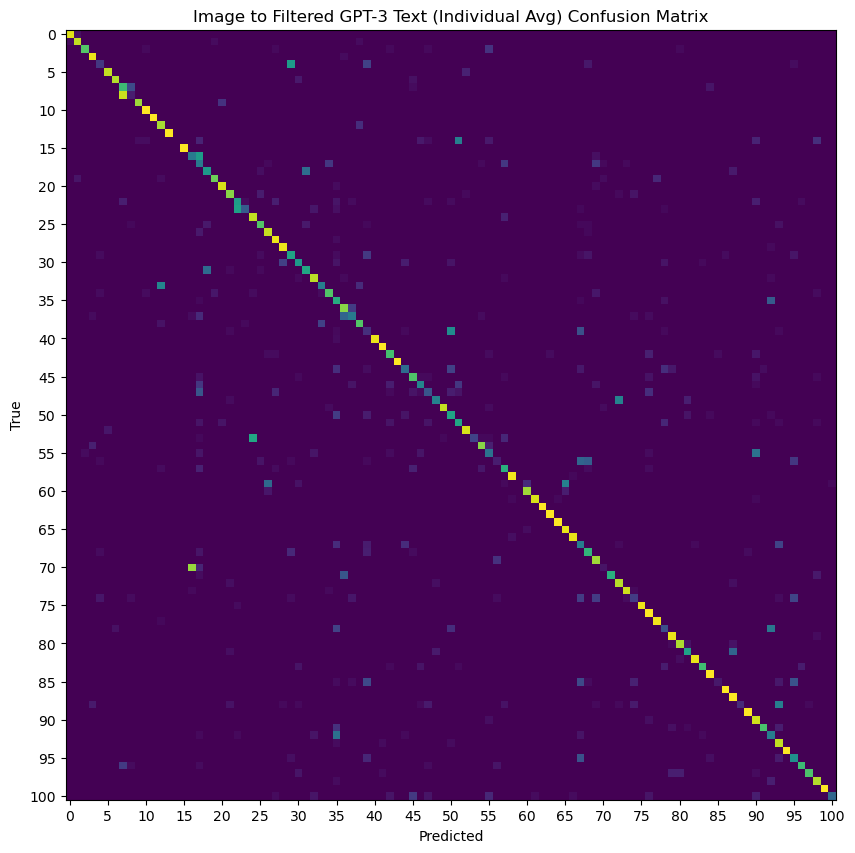

In [37]:
# Auto-similarity of image features
visualize_auto_similarity(img_masked_similarity, 'Image')

# Image to text similarity
visualize_cross_similarity(img_cls_name_similarity, cls_name_cm, 'Image to Class Name')
visualize_cross_similarity(img_template_cls_similarity, template_cls_cm, 'Image to Text Template (Centroid)')
visualize_cross_similarity(img_template_text_similarity, template_text_cm, 'Image to Text Template (Individual Avg)')
visualize_cross_similarity(img_original_gpt3_cls_similarity, original_gpt3_cls_cm, 'Image to Original GPT-3 Text (Centroid)')
visualize_cross_similarity(img_original_gpt3_text_similarity, original_gpt3_text_cm, 'Image to Original GPT-3 Text (Individual Avg)')
visualize_cross_similarity(img_filtered_gpt3_cls_similarity, filtered_gpt3_cls_cm, 'Image to Filtered GPT-3 Text (Centroid)')
visualize_cross_similarity(img_filtered_gpt3_text_similarity, filtered_gpt3_text_cm, 'Image to Filtered GPT-3 Text (Individual Avg)')

In [38]:
# Concatenate all features and labels to be used for plotting
all_label_ids = np.concatenate([cls_name_label_ids, template_label_ids, original_gpt3_label_ids, filtered_gpt3_label_ids])
all_features = np.concatenate([cls_name_features, template_text_features, original_gpt3_text_features, filtered_gpt3_text_features])

cls_name_start_idx = 0
cls_name_end_idx = len(cls_name_features)
template_start_idx = len(cls_name_features)
template_end_idx = len(cls_name_features) + len(template_text_features)
original_gpt3_start_idx = len(cls_name_features) + len(template_text_features)
original_gpt3_end_idx = len(cls_name_features) + len(template_text_features) + len(original_gpt3_text_features)
filtered_gpt3_start_idx = len(cls_name_features) + len(template_text_features) + len(original_gpt3_text_features)
filtered_gpt3_end_idx = len(cls_name_features) + len(template_text_features) + len(original_gpt3_text_features) + len(filtered_gpt3_text_features)

In [39]:
import sklearn.manifold

tsne = sklearn.manifold.TSNE(n_components=2, random_state=42, metric='cosine', perplexity=100)
transformed_features = tsne.fit_transform(all_features)

In [40]:
def calc_centroid(features, label_ids):
    return [features[label_ids == label_id].mean(axis=0) for label_id in range(len(cls_names_sorted))]

In [41]:
cls_name_transformed_features = transformed_features[cls_name_start_idx:cls_name_end_idx]
cls_name_transformed_label_ids = all_label_ids[cls_name_start_idx:cls_name_end_idx]
cls_name_transformed_centroids = calc_centroid(cls_name_transformed_features, cls_name_transformed_label_ids)
template_transformed_features = transformed_features[template_start_idx:template_end_idx]
template_transformed_label_ids = all_label_ids[template_start_idx:template_end_idx]
template_transformed_centroids = calc_centroid(template_transformed_features, template_transformed_label_ids)
original_gpt3_transformed_features = transformed_features[original_gpt3_start_idx:original_gpt3_end_idx]
original_gpt3_transformed_label_ids = all_label_ids[original_gpt3_start_idx:original_gpt3_end_idx]
original_gpt3_transformed_centroids = calc_centroid(original_gpt3_transformed_features, original_gpt3_transformed_label_ids)
filtered_gpt3_transformed_features = transformed_features[filtered_gpt3_start_idx:filtered_gpt3_end_idx]
filtered_gpt3_transformed_label_ids = all_label_ids[filtered_gpt3_start_idx:filtered_gpt3_end_idx]
filtered_gpt3_transformed_centroids = calc_centroid(filtered_gpt3_transformed_features, filtered_gpt3_transformed_label_ids)

In [42]:
import matplotlib.pyplot as plt

def plot_features_2d(features, label_ids, title):
    plt.figure(figsize=(10, 10))
    plt.scatter(features[:, 0], features[:, 1], c=label_ids, cmap='hsv')
    for label_id in range(len(cls_names_sorted)):
        plt.annotate(label_id, (features[label_ids == label_id, 0].mean(), features[label_ids == label_id, 1].mean()), ha='center', va='center', fontsize=12)
    plt.title(title)
    plt.show()

Rank 1: (7)(coor=-31,18)Basketball - (8)(coor=-31,18)Basketball_Dunk, similarity: 0.94970703125
Rank 2: (16)(coor=-43,53)Boxing_Punching_Bag - (17)(coor=-43,53)Boxing_Speed_Bag, similarity: 0.9306640625
Rank 3: (45)(coor=-58,28)Juggling_Balls - (83)(coor=-58,28)Soccer_Juggling, similarity: 0.9296875
Rank 4: (39)(coor=-25,-14)High_Jump - (50)(coor=-25,-14)Long_Jump, similarity: 0.92822265625
Rank 5: (22)(coor=-7,40)Cricket_Bowling - (23)(coor=-7,40)Cricket_Shot, similarity: 0.92041015625
Rank 6: (28)(coor=-33,37)Field_Hockey_Penalty - (84)(coor=-33,37)Soccer_Penalty, similarity: 0.916015625
Rank 7: (40)(coor=31,-4)Horse_Race - (41)(coor=31,-4)Horse_Riding, similarity: 0.91259765625
Rank 8: (36)(coor=-61,-39)Handstand_Pushups - (37)(coor=-61,-39)Handstand_Walking, similarity: 0.9072265625
Rank 9: (0)(coor=50,54)Apply_Eye_Makeup - (1)(coor=50,54)Apply_Lipstick, similarity: 0.90673828125
Rank 10: (15)(coor=-7,44)Bowling - (22)(coor=-7,44)Cricket_Bowling, similarity: 0.90283203125


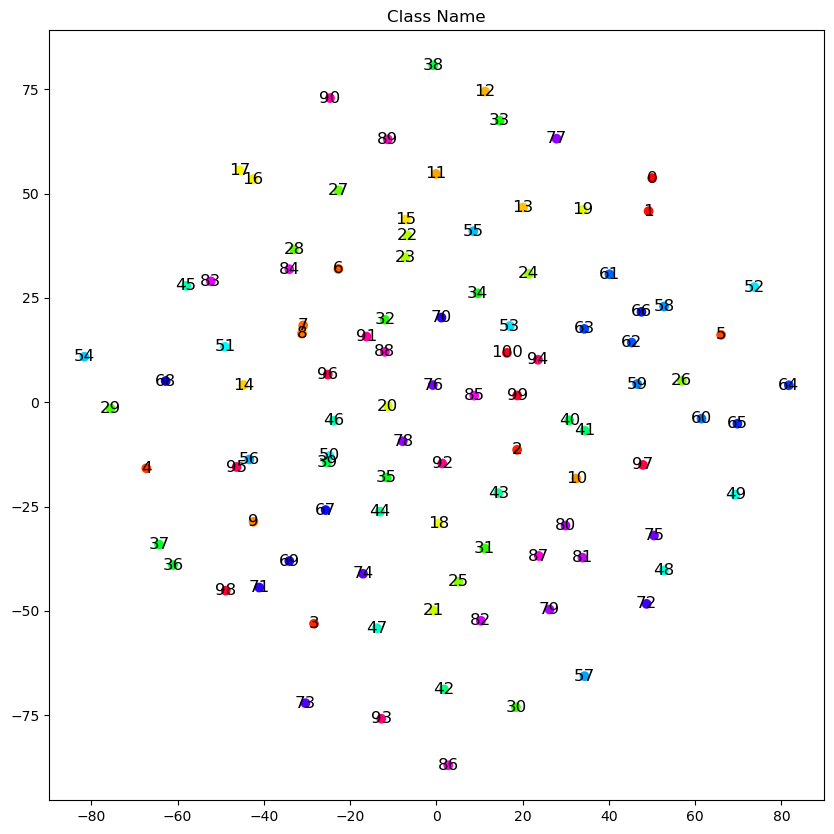

Rank 1: (39)(coor=-23,-13)High_Jump - (50)(coor=-23,-13)Long_Jump, similarity: 0.95068359375
Rank 2: (7)(coor=-28,15)Basketball - (8)(coor=-28,15)Basketball_Dunk, similarity: 0.9501953125
Rank 3: (15)(coor=-5,39)Bowling - (22)(coor=-5,39)Cricket_Bowling, similarity: 0.93408203125
Rank 4: (36)(coor=-61,-38)Handstand_Pushups - (37)(coor=-61,-38)Handstand_Walking, similarity: 0.9267578125
Rank 5: (40)(coor=30,-5)Horse_Race - (41)(coor=30,-5)Horse_Riding, similarity: 0.92431640625
Rank 6: (16)(coor=-44,53)Boxing_Punching_Bag - (17)(coor=-44,53)Boxing_Speed_Bag, similarity: 0.92431640625
Rank 7: (28)(coor=-32,35)Field_Hockey_Penalty - (84)(coor=-32,35)Soccer_Penalty, similarity: 0.92138671875
Rank 8: (45)(coor=-56,27)Juggling_Balls - (83)(coor=-56,27)Soccer_Juggling, similarity: 0.91552734375
Rank 9: (22)(coor=-5,38)Cricket_Bowling - (23)(coor=-5,38)Cricket_Shot, similarity: 0.90625
Rank 10: (58)(coor=53,22)Playing_Cello - (66)(coor=53,22)Playing_Violin, similarity: 0.89892578125


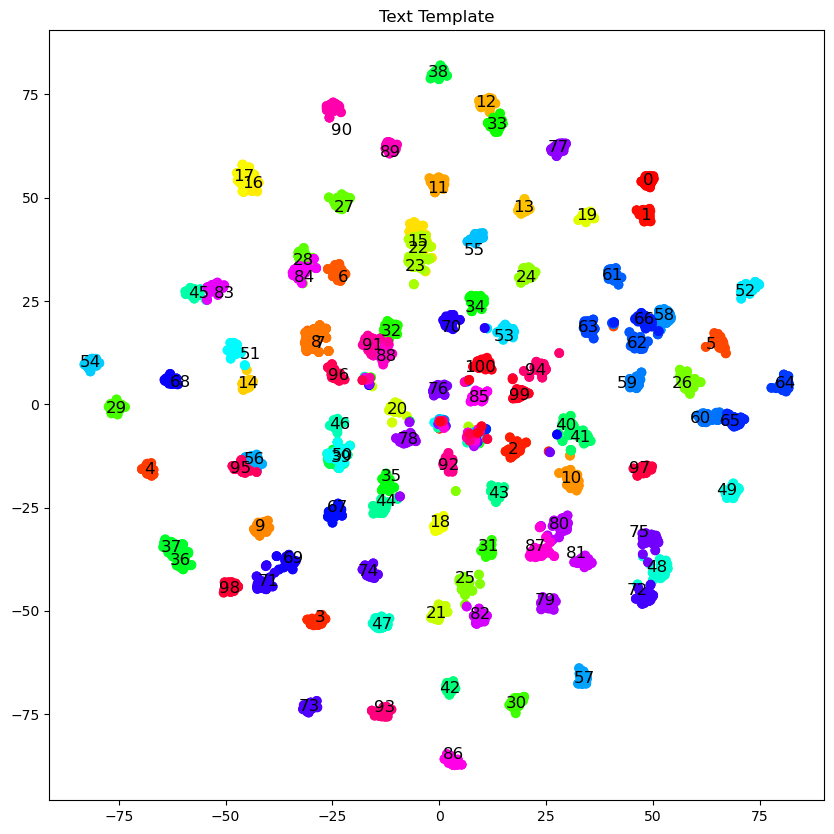

Rank 1: (18)(coor=3,-30)Breast_Stroke - (31)(coor=3,-30)Front_Crawl, similarity: 0.96142578125
Rank 2: (7)(coor=-33,20)Basketball - (8)(coor=-33,20)Basketball_Dunk, similarity: 0.95361328125
Rank 3: (16)(coor=-38,53)Boxing_Punching_Bag - (17)(coor=-38,53)Boxing_Speed_Bag, similarity: 0.951171875
Rank 4: (36)(coor=-62,-38)Handstand_Pushups - (37)(coor=-62,-38)Handstand_Walking, similarity: 0.9501953125
Rank 5: (39)(coor=-29,-17)High_Jump - (50)(coor=-29,-17)Long_Jump, similarity: 0.9443359375
Rank 6: (22)(coor=-11,39)Cricket_Bowling - (23)(coor=-11,39)Cricket_Shot, similarity: 0.9404296875
Rank 7: (40)(coor=33,-2)Horse_Race - (41)(coor=33,-2)Horse_Riding, similarity: 0.93798828125
Rank 8: (56)(coor=-53,-15)Parallel_Bars - (95)(coor=-53,-15)Uneven_Bars, similarity: 0.931640625
Rank 9: (28)(coor=-36,36)Field_Hockey_Penalty - (84)(coor=-36,36)Soccer_Penalty, similarity: 0.93017578125
Rank 10: (32)(coor=-13,22)Golf_Swing - (91)(coor=-13,22)Tennis_Swing, similarity: 0.9208984375


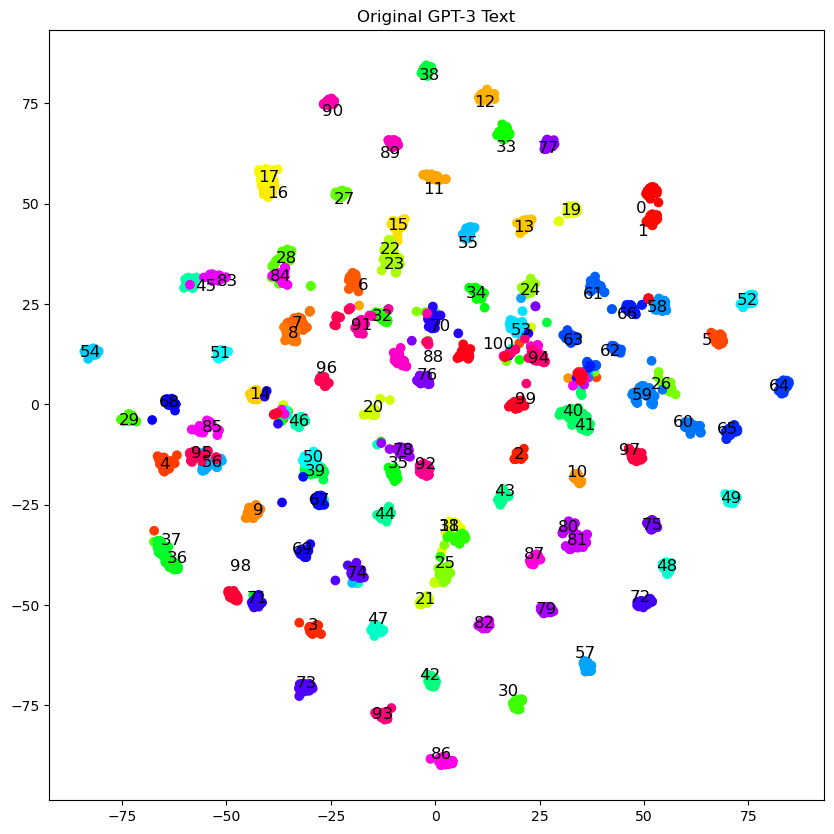

Rank 1: (18)(coor=3,-30)Breast_Stroke - (31)(coor=3,-30)Front_Crawl, similarity: 0.96142578125
Rank 2: (7)(coor=-33,20)Basketball - (8)(coor=-33,20)Basketball_Dunk, similarity: 0.95361328125
Rank 3: (36)(coor=-62,-39)Handstand_Pushups - (37)(coor=-62,-39)Handstand_Walking, similarity: 0.951171875
Rank 4: (16)(coor=-39,54)Boxing_Punching_Bag - (17)(coor=-39,54)Boxing_Speed_Bag, similarity: 0.94873046875
Rank 5: (22)(coor=-11,39)Cricket_Bowling - (23)(coor=-11,39)Cricket_Shot, similarity: 0.94677734375
Rank 6: (39)(coor=-29,-17)High_Jump - (50)(coor=-29,-17)Long_Jump, similarity: 0.94287109375
Rank 7: (40)(coor=33,-2)Horse_Race - (41)(coor=33,-2)Horse_Riding, similarity: 0.9384765625
Rank 8: (28)(coor=-36,37)Field_Hockey_Penalty - (84)(coor=-36,37)Soccer_Penalty, similarity: 0.9306640625
Rank 9: (56)(coor=-55,-15)Parallel_Bars - (95)(coor=-55,-15)Uneven_Bars, similarity: 0.93017578125
Rank 10: (32)(coor=-13,22)Golf_Swing - (91)(coor=-13,22)Tennis_Swing, similarity: 0.9228515625


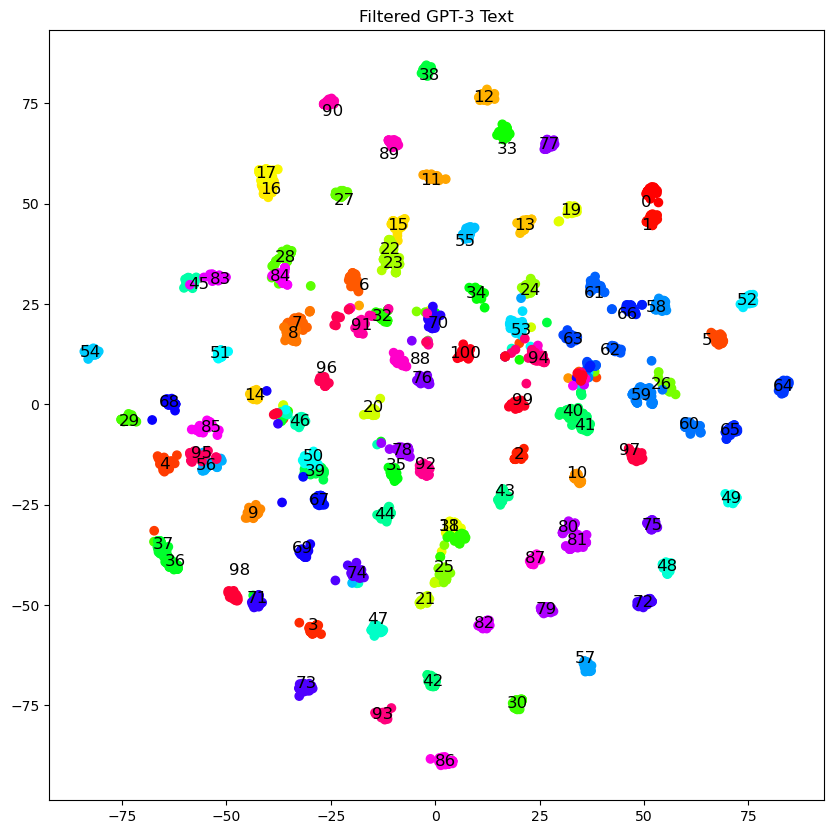

In [43]:
print_top_pairs(np.triu(cls_name_masked_similarity, k=1), 'similarity', coordinates=cls_name_transformed_centroids)
plot_features_2d(cls_name_transformed_features, cls_name_transformed_label_ids, 'Class Name')
print_top_pairs(np.triu(template_masked_similarity, k=1), 'similarity', coordinates=template_transformed_centroids)
plot_features_2d(template_transformed_features, template_transformed_label_ids, 'Text Template')
print_top_pairs(np.triu(original_gpt3_masked_similarity, k=1), 'similarity', coordinates=original_gpt3_transformed_centroids)
plot_features_2d(original_gpt3_transformed_features, original_gpt3_transformed_label_ids, 'Original GPT-3 Text')
print_top_pairs(np.triu(filtered_gpt3_masked_similarity, k=1), 'similarity', coordinates=filtered_gpt3_transformed_centroids)
plot_features_2d(filtered_gpt3_transformed_features, filtered_gpt3_transformed_label_ids, 'Filtered GPT-3 Text')